# Projet final  ( lgp @work )

### Acquisition et chargement des données

* Récupération des fichiers Excel avec les classements
* Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
* Vers la fin de la course le format des fichiers Excel change avec les arrivées des voiliers : il est possible de s'arrêter juste avant.
* Extraction des caractéristiques techniques de chacun des voiliers.




In [1]:
# Chargement des libs
import pandas as pd
import os
import sys
from bs4 import BeautifulSoup as bs
import requests
import datetime as dt
import dateparser
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# libs for xlsx "xxid" fix
import tempfile
from zipfile import ZipFile
import shutil
from fnmatch import fnmatch
import re
import glob
#

# variables utiliséees globalement
URL_RESULTS="https://www.vendeeglobe.org/fr/classement"
FILE_RESULTS="classement.html"
URL_GLOSSAIRE="https://www.vendeeglobe.org/fr/glossaire"
FILE_GLOSSAIRE="glossaire.html"
EXCELS_DIR="results"
PICKLE_DF="pickle_classement.pkl"
PICKLE_DF_TECH="pickle_classement_et_tech.pkl"


* Récupération des fichiers Excel avec les classements
* Mise en place d'une copie locale des fichiers Excel afin de ne pas les recharger à chaque run.
* Chargement dans un dataframe (clean up et split des noms de colonne, préparation des data pour traitements)

In [2]:
def get_soup_from_url(url):
    """
    Retourne la soupe de l'url du fichier html passé en paramètre
    """
    res = requests.get(url)
    soup = bs(res.content, 'html.parser')
    return soup

def get_soup_from_file(file):
    """
    Retourne la soupe du fichier html passé en paramètre
    """
    soup = bs(file, 'html.parser')
    return soup

def parse_url_for_excels(url):
    """
    Récupère la liste des fichiers excel et les télécharge dans le répertoire "results/" (EXCELS_DIR)
    """
    print("Getting url of files to download...")
    soup = get_soup_from_url(url)
    dates_list = []
    for option in soup.find_all('option'):
        if option['value'] != '':
            dates_list.append(option['value'])
    
    # format de fichiers à récupérer 
    # https://www.vendeeglobe.org/download-race-data/vendeeglobe_20210305_080000.xlsx
    print("Downloading xlsx files...")
    for date in dates_list:
        xlsx_name = f'vendeeglobe_{date}.xlsx'
        xlsx_file = requests.get(f"https://www.vendeeglobe.org//download-race-data/{xlsx_name}")
        open(os.path.join(EXCELS_DIR, xlsx_name), 'wb').write(xlsx_file.content)

def fix_xlsx_errors():
    """
    Fix des fichiers xlsx, un header xxid dans un des fichiers du xlsx n'est pas reconnu par openpyxl
    """
    print("Fixing xlsx files...")
    for file in [f for f in glob.glob(EXCELS_DIR + "/*.xlsx")]:
        change_in_zip(file, name_filter='xl/styles.xml', # the problematic property is found in the style xml files
                      change=lambda d: re.sub(b'xxid="\d*"', b"", d))
        
# fix of xlsx files
def change_in_zip(file_name, name_filter, change):
    """
    le fix appliqué à chaque fichier
    """
    tempdir = tempfile.mkdtemp()
    try:
        tempname = os.path.join(tempdir, 'new.zip')
        with ZipFile(file_name, 'r') as r, ZipFile(tempname, 'w') as w:
            for item in r.infolist():
                data = r.read(item.filename)          
                data = change(data)
                w.writestr(item, data)
        shutil.move(tempname, file_name)
    finally:
        shutil.rmtree(tempdir)


def get_excel_files():
    if not os.path.isdir(EXCELS_DIR):
        os.mkdir('results')
        print("Files being downloaded to ", EXCELS_DIR)
        parse_url_for_excels(URL_RESULTS)
        fix_xlsx_errors()
    else:
        print(f"Les fichiers sont déjà dans le répertoire \"{EXCELS_DIR}/\" et déjà traités, aucun nouveau fichier téléchargé ni traité.")


**L'appel à la commande *get_excel_files.xlsx* ne fait rien si le répertoire *results/* existe. Il est crée lors du 1er téléchargement** 

In [3]:
get_excel_files()

Les fichiers sont déjà dans le répertoire "results/" et déjà traités, aucun nouveau fichier téléchargé ni traité.


In [4]:
%%time
def create_dataframe_from_files(path, verbose=True):
    """
    Sélection des fichiers et concatenate dans une dataframe
    
    Returns a dataframe
    """
    if not verbose:
        print("Quiet mode activated. Be patient...", end='')
    dfs=[]
    for filename in [f for f in glob.glob(path + "/*.xlsx")]:
        # on exclu les fichiers donnant des infos sur les concurrents arrivées (à partir du 27 janvier)
        # on exclu le 1er fichier au départ qui est sans données
        if filename >= path+'/vendeeglobe_20210127_170000.xlsx' or filename == path+"/vendeeglobe_20201108_120200.xlsx":
            continue
        if verbose:
            print('Including file ', filename)

        # read excel
        x = pd.read_excel(filename, 
                          dtype=object,
                          skiprows=[1, 2, 3], 
                          header=1, 
                          usecols=range(1,21), 
                          skipfooter=4)
        # do not use col 0
        # remove footer
        # rename 1  Classement
        # split 2 on \n rename Pays /  Voile
        # split 3 on \n ren Skipper /  Bateau
        # change names

        # ajout colonne avec le timestamp du fichier d'où est extrait la data
        date_str = filename[-20:-5]
        x['Fichier de resultats'] = date_str
        x['Timestamp'] = pd.to_datetime(date_str, format="%Y%m%d_%H%M%S")
        dfs.append(x)
    
    df = pd.concat(dfs , ignore_index=True)
    #df.duplicated().value_counts()

    if not verbose:
        print("done")
    return df

##############################################################
## Fonction qui convertit les coordonnées en format décimal ##
##############################################################

def dms2dec(deg, mn, sec):
    return deg + mn / 60 + sec / 3600

def clean_data(df, verbose=True):
    """
    Cleanup des noms de colonnes
    """
    print('Cleaning dataframe... ', end='')

    # cleanup sur nom dde cols, etc.
    df.rename(inplace=True, columns={'Unnamed: 1': 'Classement', 'Unnamed: 2': 'Pays', 'Unnamed: 3': 'Skipper', 
                                    'Unnamed: 19': 'DTF', 'Unnamed: 20': 'DTL', "Heure FR\nHour FR": "Heure FR"})
    df[['Pays','Voile']] = df["Pays"].str.extract("(.*)\n(.*)").astype(str)
    df[['Skipper','Bateau']] = df["Skipper"].str.extract("(.*)\n(.*)").astype(str)
    df[['Heure FR']] = df["Heure FR"].str.extract("(.*)\n.*").astype(str)
    df.rename(inplace=True, columns={'Latitude\nLatitude': 'Latitude', 
                    'Longitude\nLongitude': 'Longitude', 
                    'Cap\nHeading': 'Cap 30m', 'Vitesse\nSpeed': 'Vitesse 30m', 
                    'VMG\nVMG': 'VMG 30m', 'Distance\nDistance': 'Distance 30m',
                    'Cap\nHeading.1': 'Cap dernier', 'Vitesse\nSpeed.1': 'Vitesse dernier', 
                    'VMG\nVMG.1': 'VMG dernier', 'Distance\nDistance.1': 'Distance dernier',
                    'Cap\nHeading.2': 'Cap 24h', 'Vitesse\nSpeed.2': 'Vitesse 24h', 
                    'VMG\nVMG.2': 'VMG 24h', 'Distance\nDistance.2': 'Distance 24h'})

    for col in ['Vitesse 30m','VMG 30m', 'Vitesse dernier', 'VMG dernier', 'Vitesse 24h', 'VMG 24h']:
        df[[col]] = df[col].str.extract("(.*) kts").astype(float)
    for col in ['Distance 30m', 'Distance dernier', 'Distance 24h', 'DTF', 'DTL']:
        df[[col]] = df[col].str.extract("(.*) nm").astype(float)
    for col in ['Cap 30m', 'Cap dernier', 'Cap 24h']:
        df[[col]] = df[col].str.extract("(\d*)°").astype(float)

    # classement des abandons trasnformé en int
    df[['Classement']] = df[['Classement']].applymap(lambda x: x.replace('RET', '34')).astype(str)
    df[['Classement']] = df[['Classement']].applymap(lambda x: x.replace('NL', '35')).astype(str)
    
    # VMG : Velocity Made Good = projection du vecteur vitesse sur la route théorique. Ou plus simplement : vitesse de rapprochement au but.
    # DTF : Distance To Finish = Distance théorique la plus courte pour rejoindre l'arrivée; DTL : Distance To Leader = différence de distance au but avec le premier au classement

    # suppression des lignes avec Nan
    # ce sont les abandons
    df = df.dropna()

    A = df['Longitude'].str.extract("(.*)°(..).(..)'.").astype(int)
    A['D'] = df['Longitude'].str.extract(".*'(.)").astype(str)
    df['Longitude_dec'] = dms2dec(A[0],A[1],A[2])
    df['Longitude_dec'] = np.where(A['D'] == 'W', -df['Longitude_dec'], df['Longitude_dec'])

    B = df['Latitude'].str.extract("(.*)°(..).(..)'.").astype(int)
    B['D'] = df['Latitude'].str.extract(".*'(.)").astype(str)
    df['Latitude_dec'] = dms2dec(B[0],B[1],B[2])
    df['Latitude_dec'] = np.where(B['D'] == 'S', -df['Latitude_dec'], df['Latitude_dec'])
   

    print("done")
    return df

# backup dans un fichier pickle pour ne pas retraiter à chaque run
if not os.path.isfile(PICKLE_DF):
    print(f"\nLoading data from {EXCELS_DIR}/*.xlsx files")
    df = create_dataframe_from_files(EXCELS_DIR, verbose=False)
    df = clean_data(df)
    df.to_pickle(PICKLE_DF)
    print(f"{PICKLE_DF} saved")
else:
    print(f"\nLoading data from pickle file {PICKLE_DF}...", end='')
    df = pd.read_pickle(PICKLE_DF)
    print(' done')
    print(f'\n(Note: if you need to reset pickle content remove file {PICKLE_DF} manually)')
    
df.shape



Loading data from pickle file pickle_classement.pkl... done

(Note: if you need to reset pickle content remove file pickle_classement.pkl manually)
CPU times: user 13.6 ms, sys: 7.22 ms, total: 20.8 ms
Wall time: 41.1 ms


(13703, 26)

In [5]:
df.iloc[10000]

Classement                                     29
Pays                                             
Skipper                            Clément Giraud
Heure FR                                 12:30 FR
Latitude                               38°56.43'N
Longitude                              19°07.68'W
Cap 30m                                     228.0
Vitesse 30m                                   4.2
VMG 30m                                       3.3
Distance 30m                                  2.1
Cap dernier                                 177.0
Vitesse dernier                               3.8
VMG dernier                                   3.7
Distance dernier                             11.4
Cap 24h                                     241.0
Vitesse 24h                                   8.2
VMG 24h                                       5.7
Distance 24h                                196.7
DTF                                       23557.6
DTL                                         370.4




#### Extraction des caractéristiques techniques de chacun des voiliers.

* Extraction des caractéristiques techniques de chacun des voiliers depuis la page glossaire 
* ajout des informations sur la présence de foils depuis la page classement



Traitement manuel de la page web https://www.vendeeglobe.org/fr/classement pour récupérer l'info sur les foils et le classement final

In [6]:
def get_infos_from_classement(df):
    """
    Récupère les infos skipper, foil, etc.
    
    Retourne une liste de liste de [classement final, nom skipper, Oui/Non (foil)]
    """
    print("Getting boats infos...")
    classement_html=""
    if not os.path.isfile(FILE_RESULTS):
        print("Reading file from far away")
        req = requests.get(URL_RESULTS)
        classement_html = req.content
        open(os.path.join(FILE_RESULTS), 'wb').write(classement_html)
    else:
        print("Reading file locally")
        with open(FILE_RESULTS,'r') as file:
            classement_html = file.read()

    soup = get_soup_from_file(classement_html)
    skippers_info=[]
    for ranking_row in soup.find_all("tr", {"class": "ranking-row"}):
        cell_rank = ranking_row.find('td', attrs={'class': 'row-number'} ).text
        cell_skipper = ranking_row.find('td', attrs={'class': 'row-skipper'} ).contents[2]
        cell_skipper = re.search(r'\n\s+(\w[\s\'\w-]*)', cell_skipper).group(1).title()
        cell_has_foil = ranking_row.find('td', attrs={'class': 'row-layout'} ).text
        skippers_info.append([cell_rank, cell_skipper, cell_has_foil])
    return skippers_info

# Extraction des caractéristiques techniques de chacun des voiliers.
def get_infos_from_glossaire():
    """
    Récupère les infos skipper, foil, etc.
    """
    if not os.path.isfile(FILE_GLOSSAIRE):
        print("Reading file from far away..." , end='')
        req = requests.get(URL_GLOSSAIRE)
        glossaire_html = req.content
        open(os.path.join(FILE_GLOSSAIRE), 'wb').write(glossaire_html.content)
    else:
        print("Reading file locally... " , end='')
        with open(FILE_GLOSSAIRE,'r') as file:
            glossaire_html = file.read()

    soup = get_soup_from_file(glossaire_html)
    
    tech_info={}
    
    boats_popup_infos = soup.find_all('div', attrs={'class': 'boats-list__popup-infos'})
    specs_list = soup.find_all('ul', attrs={'class': 'boats-list__popup-specs-list'})
#     print(len(boats_popup_infos), len(specs_list))
#     v = []
    for i in range(len(boats_popup_infos)):
        bateau = boats_popup_infos[i].h3.text
        specs = specs_list[i]
        voile = specs.find(string=re.compile("Numéro de voile : "))
        if voile == None:
            voile = 0
        else:
            voile = re.match(".*: ([\w\s]+)", voile)[1]
        anc_name = specs.find(string=re.compile("Anciens noms du bateau : "))
        if anc_name==None:
            anc_name = bateau
        else:    
            anc_name = re.match(".*: ([,\w\s]+)", anc_name)[1]
        Architecte = specs.find(string=re.compile("Architecte")) # : Marc Lombard</li>
        Architecte = re.match(".*: ([\s\w]+)", Architecte)[1]
        Chantier= specs.find(string=re.compile("Chantier")) #MAG France</li>
        Chantier= re.match(".*: ([\s\w]+)", Chantier)[1]
        lancement= specs.find(string=re.compile("Date de lancement")) # : 01 Mars 1998</li>
        lancement= re.match(".*: ([\s\w]+)", lancement)[1]
        Longueur= specs.find(string=re.compile("Longueur")) # : 18,28m</li>
        Longueur= re.match(".*: ([,.\d]+)", Longueur)[1]
        Largeur = specs.find(string=re.compile("Largeur")) # : 5,54m</li>
        Largeur = re.match(".*: ([,\d]+)", Largeur)[1]
        Tirant = specs.find(string=re.compile("Tirant d'eau")) # : 4,50m</li>
        Tirant = re.match(".*: ([,\d]+)", Tirant)[1]
        poids = specs.find(string=re.compile("Déplacement")) # : 9t</li>
        poids = re.match(".*: ([,\dncNC]+)\s?t?", poids)[1]
        if poids=="nc" or poids=="NC":
            poids="0"
        derives = specs.find(string=re.compile("Nombre de dérives")) # : 2</li>
        derives = re.match(".*: (.*)", derives)[1]
        mat = specs.find(string=re.compile("Hauteur mât")) # : 29 m</li>
        mat = re.match(".*: ([,\d]+)", mat)[1]
        quille = specs.find(string=re.compile("Voile quille")) # : acier</li>
        if quille == None:
            quille = "NC"
        else:
            quille = re.match(".*: ([\s\w]+)", quille)[1].lower() 
        Surface_pres = specs.find(string=re.compile("Surface de voiles au près")) # : 260 m2</li>
        Surface_pres = re.match(".*: ([,\d]+).*m[2²]", Surface_pres)[1]
        Surface_portant = specs.find(string=re.compile("Surface de voiles au portant")) # : 580 m2</li>
        Surface_portant = re.match(".*: ([,\d]+).*m[2²]", Surface_portant)[1]

        # manual cleanup des numéros de voiles qui ne matchent pas avec les fichiers classements
        if bateau == 'LinkedOut':
            voile = "FRA 59"
        if voile == "001":
            voile = "FRA 01"
        if voile == "4":
            voile = "FRA 4" 
        if voile == "2":
            voile = "FRA 02"
#         if voile == "6":
#                 voile = "FRA 6"
        if voile == "08":
            voile = "FRA 8"
        if voile == "16":
            voile = "MON 10"
        if voile == "17":
            voile = "FRA 17"
        if voile == "18":
            voile = "FRA 18"
        if voile == "69":
            voile = "FRA 69"
        if voile == "SUI07":
            voile = "SUI 7"
        if voile == "GBR77":
            voile = "GBR 777"
        if voile[3] != " ":
#             print(voile)
            voile = voile[0:3]+" "+voile[3:]
#             print(voile)
        tech_info[voile] = {'Voile': voile, 'Nom bateau': bateau, 'Longueur': Longueur, 
                            'Largeur': Largeur, 'Tirant': Tirant, 
                           'Poids': poids, "Dérives": derives,
                           'Hauteur mât': mat, "Quille": quille, 
                            "Surface près": Surface_pres,  "Surface portant": Surface_portant,
                           "Année lancement": lancement[-4:], 'Ancien nom': anc_name}
#         v.append(voile)
    print("Done")
    return tech_info



In [7]:

foils_etc = get_infos_from_classement(df)

# manual fixes
# skippers with names not matching
# from web page 2 errors
skips=set()
for f in foils_etc:
    skipper=f[1]
    skips.add(skipper)
all_skips = set(df['Skipper'])
# print(skips.difference(set(all_skips)))
df[['Skipper']] = df[['Skipper']].applymap(lambda x: x.replace('Arnaud Boissieres', 'Arnaud Boissières')).astype(str)

for f in foils_etc:
    if f[1]=="Sam Davies":
        skipper = "Samantha Davies"
    elif f[1]=="Alan  Roura":
        skipper="Alan Roura"
    else:
        skipper=f[1]
    foil=f[2]
    
    df.loc[df['Skipper']==skipper, 'Foil'] = foil
    df.loc[df['Skipper']==skipper, 'Classement final'] = f[0]

df[['Classement final']] = df[['Classement final']].applymap(lambda x: x.replace('ABD', '34')).astype(str)
df[['Classement final']] = df[['Classement final']].astype(int)
df[['Classement']] = df[['Classement']].astype(int)


# set(df['Skipper'])
df[['Foil']] = df[['Foil']].applymap(lambda x: x.replace('Oui', '1')).astype(str)
df[['Foil']] = df[['Foil']].applymap(lambda x: x.replace('Non', '0')).astype(str)
df[['Foil']] = df[['Foil']].astype(int)
# df[['Foil']] = df[['Foil']].astype(bool)



Getting boats infos...
Reading file locally


In [8]:
#################################################################################
# MERGE DES CLASSEMENTS ET DONNEES TECHNIQUES


# tech_info contains a dict of technical details
# backup dans un fichier pickle pour ne pas retraiter à chaque run
# https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#brief-primer-on-merge-methods-relational-algebra


mapping_quilles={}
mapping_derives={}
mapping_inv_quilles={}
mapping_inv_derives={}
def last_cleanup(df):
    ## cleanup columns types, changing categorical values to numbers, renaming and ordering

    df['Tirant'] = df["Tirant"].str.replace(',','.').astype(float)
    df['Longueur'] = df["Longueur"].str.replace(',','.').astype(float)
    df['Largeur'] = df["Largeur"].str.replace(',','.').astype(float)
    df['Poids'] = df["Poids"].str.replace(',','.').astype(float)
    df["Hauteur mât"] = df["Hauteur mât"].str.replace(',','.').astype(float)
    df["Surface près"] = df["Surface près"].str.replace(',','.').astype(float)
    df["Surface portant"] = df["Surface portant"].str.replace(',','.').astype(float)
    df["Année lancement"] = df["Année lancement"].astype(int)


    for i, name in enumerate(sorted(df['Quille'].unique())):
        mapping_quilles[i]=name
        mapping_inv_quilles[name]=i
    for i, name in enumerate(sorted(df['Dérives'].unique())):
        mapping_derives[i]=name
        mapping_inv_derives[name]=i

    # traitement du gender
    df['Dérives'] = df['Dérives'].map(mapping_inv_derives)
    df['Quille']  = df['Quille'].map(mapping_inv_quilles)
    df['Dérives'] = df['Dérives'].astype(int)
    df['Quille']  = df['Quille'].astype(int)

    columns=['Timestamp', 'Classement', 'Classement final', 'Skipper', 'Bateau', 'Voile', 'Pays', 'Heure FR', 'Latitude', 'Longitude',
           'Cap 30m', 'Vitesse 30m', 'VMG 30m', 'Distance 30m', 'Cap dernier',
           'Vitesse dernier', 'VMG dernier', 'Distance dernier', 'Cap 24h',
           'Vitesse 24h', 'VMG 24h', 'Distance 24h', 'DTF', 'DTL',
             'Latitude', 'Longitude', 'Latitude_dec', 'Longitude_dec',
           'Fichier de resultats', 'Foil', 'Dérives', 'Tirant', 'Longueur', 'Largeur', 'Poids', 
           'Hauteur mât', 'Quille', 'Surface près', 'Surface portant',
           'Année lancement', 'Ancien nom']

    df = df[columns]
    return(df)

def merge(df):
    if not os.path.isfile(PICKLE_DF_TECH):  
        print(f"\nLoading boats technical data")
        tech_info = get_infos_from_glossaire()

        print(f"\nMerging df with technical data")
        df_tech_info = pd.DataFrame(tech_info).T        
        df_merge = pd.merge(df, df_tech_info, on="Voile")
        df_merge = last_cleanup(df_merge)
        df = df.reset_index()
        df = df.set_index('Timestamp').sort_index()
        
        df_merge.to_pickle(PICKLE_DF_TECH)
        print(f"Pickle file {PICKLE_DF_TECH} saved.")
    else:
        print(f"\nLoading data from pickle file {PICKLE_DF_TECH}...", end='')
        df_merge = pd.read_pickle(PICKLE_DF_TECH)
        df_merge = df_merge.set_index('Timestamp').sort_index()

        print(' done')
        print(f'\n(Note: if you need to renew pickle content remove file {PICKLE_DF_TECH} manually)')
    return df_merge

df = merge(df)
df = df.reset_index()
df = df.set_index('Timestamp').sort_index()
        
mapping_derives, mapping_quilles



Loading data from pickle file pickle_classement_et_tech.pkl... done

(Note: if you need to renew pickle content remove file pickle_classement_et_tech.pkl manually)


({}, {})

### Dataframe prêt

Nous avons maintenant un dataframe complet avec toutes nos données.

Il comporte les données numériques y comppris le mapptignd e certianes cat"gories (dérives et quilles) détaillé ci-après.

#### Fichiers inclus/exclus

J'ai pris l'optino de ne pas intégrer les fichiers vers la fin de la course comme proposé dans l'énoncé. Les fichiers aprsè le 20210127_170000 ne sont pas intégrées au dataframe.

#### Classement général et classement final

Concernant les classements la position 34 représente un abandon.

#### Mapping  quilles et dérives

A l'étape précédente j'ai crée 2 mappings de données catégorielles pour les dérives et les quilles.
Les quilles et dérives en fonction des matériaux sont regroupés comme ceci.

<pre>
Mapping des dérives :
0: '2'
1: '2 asymétriques'
2: 'foiler'
3: 'foils'

Mapping des quilles:
0: 'NC'
1: 'acier'
2: 'acier forgé'
3: 'acier mécano soudé'
4: 'basculante avec vérin'
5: 'basculante sur vérin hydraulique'
6: 'carbone'
7: 'inox usiné'
8: 'monotype'
</pre>

#### Coordonnées 

La coordonnées au foramt exploitable ppour positionnementsr une carte


**Contrôle d'une donnée et des Dtypes**

In [9]:
df.iloc[2546]

Classement                             8
Classement final                       1
Skipper                 Yannick Bestaven
Bateau                     Maître Coq IV
Voile                             FRA 17
Pays                                    
Heure FR                        11:30 FR
Latitude                      15°13.62'S
Longitude                     30°48.54'W
Cap 30m                            171.0
Vitesse 30m                         18.1
VMG 30m                             17.1
Distance 30m                         9.1
Cap dernier                        175.0
Vitesse dernier                     19.9
VMG dernier                         18.4
Distance dernier                    59.7
Cap 24h                            177.0
Vitesse 24h                         18.6
VMG 24h                             17.8
Distance 24h                       447.4
DTF                              20465.7
DTL                                392.3
Latitude                      15°13.62'S
Longitude       

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13703 entries, 2020-11-08 14:00:00 to 2021-01-27 14:00:00
Data columns (total 40 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Classement            13703 non-null  int64  
 1   Classement final      13703 non-null  int64  
 2   Skipper               13703 non-null  object 
 3   Bateau                13703 non-null  object 
 4   Voile                 13703 non-null  object 
 5   Pays                  13703 non-null  object 
 6   Heure FR              13703 non-null  object 
 7   Latitude              13703 non-null  object 
 8   Longitude             13703 non-null  object 
 9   Cap 30m               13703 non-null  float64
 10  Vitesse 30m           13703 non-null  float64
 11  VMG 30m               13703 non-null  float64
 12  Distance 30m          13703 non-null  float64
 13  Cap dernier           13703 non-null  float64
 14  Vitesse dernier       13703 non-nul

## Analyse des données


############################## AT WORK BELOW THIS LINE #####################################

* Rapprochement des données des voiliers avec celle des classements.
* Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
* Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
* Visualisation de la distance parcourue par voilier.
* Cartes avec les routes d'un ou plusieurs voiliers.
* Analyses de séries temporelles.
* Application d'algorithmes statistiques ou de machine learning.
* etc.

Analyse des caractériqtiques impactantante ou facilement visibles

In [11]:
# column_values = df[['Bateau', 'Voile']].values.ravel()
# unique_values =  pd.unique(column_values)
# unique_values
# s = set(df['Voile'].unique())
# s1-s

In [12]:
df_classements_14h = df.loc[ df['Fichier de resultats'].str.endswith("140000")]
df_classements_14h.head(1)

,Classement,Classement final,Skipper,Bateau,Voile,Pays,Heure FR,Latitude,Longitude,Cap 30m,...,Tirant,Longueur,Largeur,Poids,Hauteur mât,Quille,Surface près,Surface portant,Année lancement,Ancien nom
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-11-08 14:00:00,24,20,Didac Costa,One Planet One Ocean,ESP 33,,15:30 FR,46°25.59'N,01°48.85'W,238.0,...,4.5,18.28,5.3,8.9,26.0,1,240.0,470.0,2000,Kingfisher


In [13]:
df.columns

Index(['Classement', 'Classement final', 'Skipper', 'Bateau', 'Voile', 'Pays',
       'Heure FR', 'Latitude', 'Longitude', 'Cap 30m', 'Vitesse 30m',
       'VMG 30m', 'Distance 30m', 'Cap dernier', 'Vitesse dernier',
       'VMG dernier', 'Distance dernier', 'Cap 24h', 'Vitesse 24h', 'VMG 24h',
       'Distance 24h', 'DTF', 'DTL', 'Latitude', 'Longitude', 'Latitude_dec',
       'Longitude_dec', 'Fichier de resultats', 'Foil', 'Dérives', 'Tirant',
       'Longueur', 'Largeur', 'Poids', 'Hauteur mât', 'Quille', 'Surface près',
       'Surface portant', 'Année lancement', 'Ancien nom'],
      dtype='object')

#### Dataframe de données numériques uniquement

In [14]:
cols_temp = ['Classement', 'Classement final', 'Skipper', \
             'Bateau', 'Voile', 'Pays', 'Heure FR', 'Latitude', 'Longitude','Latitude_dec', 'Longitude_dec', \
             'Cap 24h', 'Vitesse 24h', 'VMG 24h', 'Distance 24h', 'DTF', 'DTL', \
             'Fichier de resultats', 'Foil', 'Dérives', 'Tirant', 'Longueur', 'Largeur', \
             'Poids', 'Hauteur mât', 'Quille', 'Surface près', 'Surface portant', \
             'Année lancement', 'Ancien nom']
df_temp = df_classements_14h[cols_temp]

def df_with_numerical_columns(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    num_df = df.select_dtypes(include=numerics)
    return num_df

num_df = df_with_numerical_columns(df_temp)

num_df


,Classement,Classement final,Latitude_dec,Longitude_dec,Cap 24h,Vitesse 24h,VMG 24h,Distance 24h,DTF,DTL,...,Dérives,Tirant,Longueur,Largeur,Poids,Hauteur mât,Quille,Surface près,Surface portant,Année lancement
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-11-08 14:00:00,24,20,46.433056,-1.823611,193.0,0.7,0.6,4.7,24295.4,1.5,...,0,4.5,18.28,5.30,8.9,26.0,1,240.0,470.0,2000
2020-11-08 14:00:00,29,34,46.437500,-1.820278,192.0,0.2,0.1,4.5,24295.5,1.6,...,2,4.5,18.28,5.70,8.0,29.0,7,260.0,600.0,2019
2020-11-08 14:00:00,16,34,46.433889,-1.826667,197.0,0.1,0.1,4.7,24295.1,1.2,...,3,4.5,18.28,5.70,7.8,27.0,2,300.0,600.0,2010
2020-11-08 14:00:00,19,16,46.428333,-1.816667,193.0,0.2,0.2,4.9,24295.2,1.3,...,3,4.5,18.28,5.85,8.0,29.0,2,320.0,580.0,2019
2020-11-08 14:00:00,7,4,46.425000,-1.830278,196.0,0.2,0.2,5.5,24294.7,0.8,...,0,4.5,18.28,5.90,8.0,28.0,2,300.0,620.0,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-27 14:00:00,16,17,-0.358889,-31.620556,359.0,14.0,13.0,335.1,3250.4,3169.9,...,3,4.5,18.28,5.90,0.0,27.0,6,290.0,580.0,2007
2021-01-27 14:00:00,1,2,46.235278,-3.700278,61.0,13.9,13.9,334.3,80.5,0.0,...,3,4.5,18.28,5.85,8.0,29.0,1,350.0,560.0,2019
2021-01-27 14:00:00,13,14,14.201944,-35.049444,349.0,12.3,9.5,296.3,2562.4,2481.9,...,0,4.5,18.28,5.80,9.0,28.0,2,280.0,560.0,2007


In [15]:
nom_colonne_y = "Classement final"
Y = num_df[nom_colonne_y]

In [16]:
num_df.columns
num_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2302 entries, 2020-11-08 14:00:00 to 2021-01-27 14:00:00
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Classement        2302 non-null   int64  
 1   Classement final  2302 non-null   int64  
 2   Latitude_dec      2302 non-null   float64
 3   Longitude_dec     2302 non-null   float64
 4   Cap 24h           2302 non-null   float64
 5   Vitesse 24h       2302 non-null   float64
 6   VMG 24h           2302 non-null   float64
 7   Distance 24h      2302 non-null   float64
 8   DTF               2302 non-null   float64
 9   DTL               2302 non-null   float64
 10  Foil              2302 non-null   int64  
 11  Dérives           2302 non-null   int64  
 12  Tirant            2302 non-null   float64
 13  Longueur          2302 non-null   float64
 14  Largeur           2302 non-null   float64
 15  Poids             2302 non-null   float64
 16  Hauteu

#### Repérage sur les données

On affiche plusieurs plaiplot pour visualliser des indices de causalité ou des corrélations

In [17]:
cols1=['Classement', 'Classement final', 'Cap 24h',  'Distance 24h', 'Tirant', 'Longueur' ]
cols2=['Classement', 'Classement final', 'DTF', 'DTL', 'Vitesse 24h', 'Largeur']
cols3=['Classement', 'Classement final', 'Poids', 'Hauteur mât', 'Surface près',
       'Surface portant', 'Année lancement']
cols4=['Classement', 'Classement final', 'Foil', 'Dérives', 'Quille', 'Année lancement', 'Surface près',
       'Surface portant']
cols5=[ 'Année lancement', 'Classement final', 'Foil', 'Dérives', 'Poids' ]
cols6=['Foil', 'Poids']
# df1 = num_df[cols1]
# df2 = num_df[cols2]
# df3 = num_df[cols3]
# df4 = num_df[cols4]
# df5 = num_df[cols5]
# df6 = num_df[cols6]
df1 = df[cols1]
df2 = df[cols2]
df3 = df[cols3]
df4 = df[cols4]
df5 = df[cols5]
df6 = df[cols6]
# df6.reset_index()

In [18]:
# sns.pairplot(df6)
# df6.columns

In [19]:
# sns.pairplot(df5)
# df5.columns

In [20]:
# sns.pairplot(df4)
# df4.columns

In [21]:
# sns.pairplot(df1)
# df1.columns

In [22]:
# sns.pairplot(df2)
# df2.columns

In [23]:
# sns.pairplot(df3)
# df3.columns

In [24]:
nom_colonne_y = "Classement final"

def show_graphs(num_df, nom_colonne_y):
    Y = num_df[nom_colonne_y]
    X_cols=[]
    X_cols = num_df.columns.to_list()
    # on enlève le nom de la colonne Y
    X_cols.remove(nom_colonne_y)

    X = num_df[X_cols]

    ncols=3
    nrows=int((len(num_df.columns)-1)/ncols)+ min(1, (len(num_df.columns)-1)%ncols)

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(25 , 25))

    

    for i, ax ,col in zip(range(len(num_df.columns)-1), axes.flat, X_cols):
        ax.scatter(Y, X[col])
        ax.set_title(col + "/"+nom_colonne_y , fontsize = 16)
        ax.set_xlabel(nom_colonne_y, fontsize = 16)
        ax.set_ylabel(col, fontsize = 16)
    #     sns.distplot(data[i,0,0,0], hist=False, ax=ax)
    fig.tight_layout()
    plt.show()
    
    
def show_one_graph(num_df, nom_colonne_y, nom_colonne_x):
    Y = num_df[nom_colonne_y]
    X_cols=[nom_colonne_x]    
    X = num_df[X_cols]

    ax = plt.subplot(111)
    ax.scatter(Y, X)
    ax.set_title(nom_colonne_x + "/" + nom_colonne_y , fontsize = 16)
    ax.set_xlabel(nom_colonne_y, fontsize = 16)
    ax.set_ylabel(nom_colonne_x, fontsize = 16)
#     fig.tight_layout()
    plt.show()
    


In [25]:

def show_one_graph(df, nom_colonne_x, nom_colonne_y):
    Y = df[nom_colonne_y]
    X_cols=[nom_colonne_x]    
    X = df[X_cols]

    ax = plt.subplot(111)
    ax.scatter(Y, X)
    ax.set_title(nom_colonne_x + "/" + nom_colonne_y , fontsize = 16)
    ax.set_xlabel(nom_colonne_y, fontsize = 16)
    ax.set_ylabel(nom_colonne_x, fontsize = 16)
#     fig.tight_layout()
    plt.show()

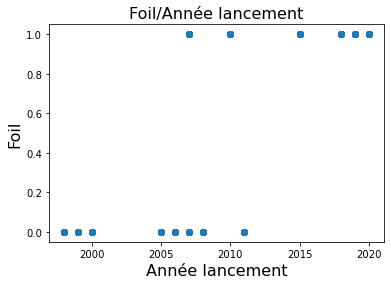

In [26]:
show_one_graph(num_df, "Foil", "Année lancement")

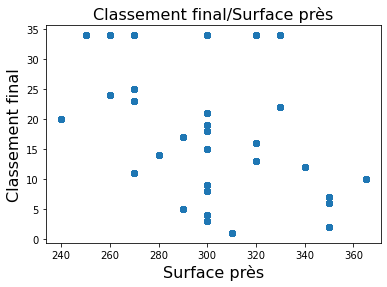

In [27]:
show_one_graph(num_df,  "Classement final", "Surface près")


## Analyse de l'influence de la présence d'un foil 

On va observer que le foil présente des avantages et des inconvénients quant à l'effet sur le classement. 

Les foils sont un équipement assez récent (voir graphe X)
Sur bateuax élgers


### Présence d'un foil et classement à l 'arrivée

Tout d'abord analysons le classement à l'arrivée des bateaux avec et sans foil

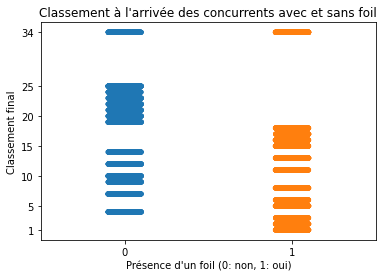

In [118]:
sns.stripplot(data=df, y='Classement final', x='Foil')
plt.title("Classement à l'arrivée des concurrents avec et sans foil");
plt.xticks([0, 1]) # change xticks labels
plt.xlabel("Présence d'un foil (0: non, 1: oui)")
plt.yticks([1, 5, 10, 15, 20, 25, 34]);

On observe que les bateaux avec foils semblent présenter un avantage. L'ensemble des 12 concurrents disposant de foils arrivent parmis les 17 premiers, laissant 7 concurrents sans foils derrière eux. Les 3 premiers sont équipés de foils. Ce qui pourrait laisser croire à un net avantage des bateaux avec foils.

On botera toutefois que le nom d'abandons des foils est très élevés (7 contre 1) tel que l'illustre les requêtes ci-après:

In [114]:
# nombre d'abandons selon la présence ou non de foil

abandon_foil = df.loc[df['Classement final'].isin([34]) & df['Foil'].isin([1]), "Skipper"].unique()
abandon_sans_foil = df.loc[df['Classement final'].isin([34]) & df['Foil'].isin([0]), "Skipper"].unique()
# len(df.loc[df['Skipper'].isin(abandons) & df['Foil']==1, "Skipper"].unique())
print(f"{len(abandon_foil)} bateaux avec foil ont abandonné \n\tdont skippers {abandon_foil}")
print(f"\n\n{len(abandon_sans_foil)} bateau sans foil a abandonné \n\tdont skippers {abandon_foil}")


7 bateaux avec foil ont abandonné 
	dont skippers ['Sébastien Simon' 'Samantha Davies' 'Alex Thomson' 'Fabrice Amedeo'
 'Nicolas Troussel' 'Kevin Escoffier' 'Isabelle Joschke']


1 bateau sans foil a abandonné 
	dont skippers ['Sébastien Simon' 'Samantha Davies' 'Alex Thomson' 'Fabrice Amedeo'
 'Nicolas Troussel' 'Kevin Escoffier' 'Isabelle Joschke']


### Présence de foil sur quels bateaux ?

On note que les foils sont pésents sur les bateaux à partir de 2007.
Il n'y a pas de bateaux sans foils après 2012.

<AxesSubplot:xlabel='Foil', ylabel='Année lancement'>

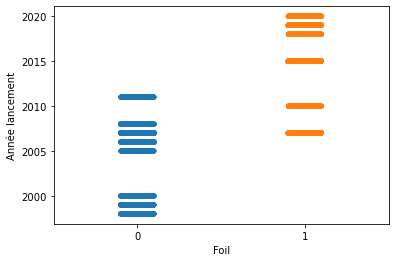

In [151]:
sns.stripplot(data=df, y='Année lancement', x='Foil')

In [161]:
df.loc[df["Foil"]==1, "Année lancement"].unique()

array([2019, 2010, 2015, 2020, 2007, 2018])

In [162]:
df.loc[df["Dérives"]==3, "Année lancement"].unique()

array([2010, 2019, 2015, 2020, 2007, 2018])

### Vitesses / Classement général

On observe qe la vitesse est globalement plus élevées pour les bateaux avec foils  tel qu'illustré dans les 2 séries de graphes ci-après.

La série de deux graphes ci-dessous affichent la moyenne de la vitesse des 10 premiers bateaux disposant de foil et des 10 premiers sans foil sur les dernières 24h et en moyenne glissante sur 5 jours.

ON remarque que la courbe bleue est sensiblement au-dessus en moyenne et très nettement sur 5 jours glissants.

In [180]:
dfz= df.copy()
dfz = dfz.loc[dfz['Fichier de resultats'].str.endswith("140000")]

[1, 2, 3, 5, 6, 8, 11, 13, 15, 16, 17, 18, 25, 34]
[4, 7, 9, 10, 12, 14, 19, 20, 21, 22, 23, 24, 25, 34]
81


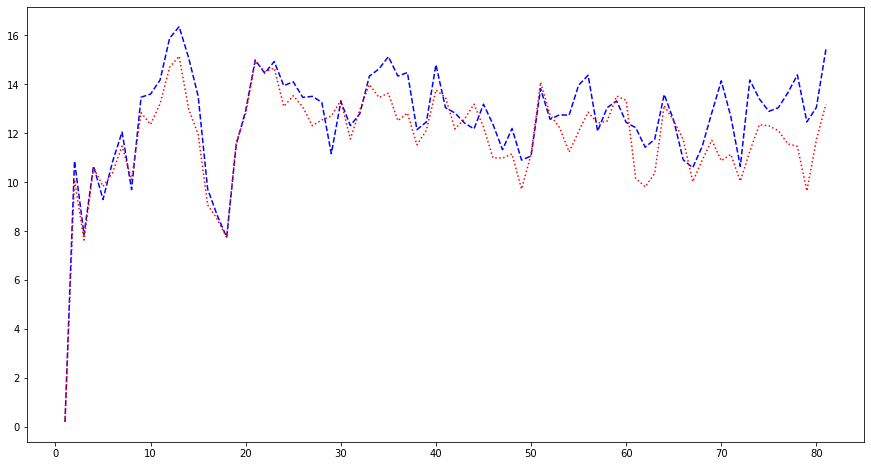

In [185]:
fig = plt.subplots(1, figsize=(15,8))

classes_with_foils = dfz.loc[dfz['Foil']==1 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
classes_without_foils = dfz.loc[dfz['Foil']==0 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
print(sorted(classes_with_foils))
print(sorted(classes_without_foils))

ROLLING=1
NUM_PREMIER=1
NUM_DERNIER=12
CRITERE='Vitesse 24h'

# WITH FOILS
# for i  in classes_with_foils[1:4]:
#     print(i)
#     skipper = dfz.loc[dfz['Classement final']==i, 'Skipper'].unique().tolist()
sw = dfz.loc[dfz['Classement final'].isin(classes_with_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Fichier de resultats']]
sw = sw.groupby('Fichier de resultats').mean()
sw = (sw).rolling(ROLLING).mean()
print(len(sw))
xabs=np.linspace(1, len(sw), len(sw))
plt.plot(xabs, sw, "b--")

# WITHOUT FOILS
swo = dfz.loc[dfz['Classement final'].isin(classes_without_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Fichier de resultats']]
swo = swo.groupby('Fichier de resultats').mean()
swo = (swo).rolling(ROLLING).mean()
xabs=np.linspace(1, len(swo), len(swo))
plt.plot(xabs, swo, "r:")


[1, 2, 3, 5, 6, 8, 11, 13, 15, 16, 17, 18, 25, 34]
[4, 7, 9, 10, 12, 14, 19, 20, 21, 22, 23, 24, 25, 34]
81


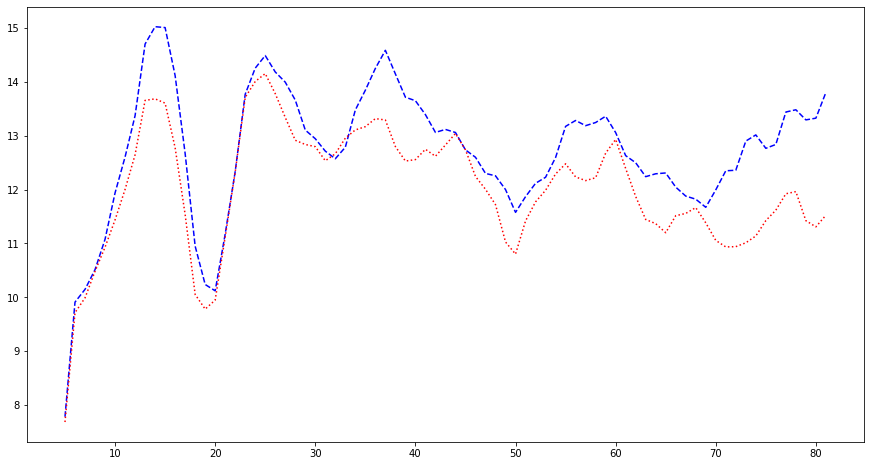

In [186]:
fig = plt.subplots(1, figsize=(15,8))

classes_with_foils = dfz.loc[dfz['Foil']==1 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
classes_without_foils = dfz.loc[dfz['Foil']==0 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
print(sorted(classes_with_foils))
print(sorted(classes_without_foils))

ROLLING=5
NUM_PREMIER=1
NUM_DERNIER=12
CRITERE='Vitesse 24h'

# WITH FOILS
# for i  in classes_with_foils[1:4]:
#     print(i)
#     skipper = dfz.loc[dfz['Classement final']==i, 'Skipper'].unique().tolist()
sw = dfz.loc[dfz['Classement final'].isin(classes_with_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Fichier de resultats']]
sw = sw.groupby('Fichier de resultats').mean()
sw = (sw).rolling(ROLLING).mean()
print(len(sw))
xabs=np.linspace(1, len(sw), len(sw))
plt.plot(xabs, sw, "b--")

# WITHOUT FOILS
swo = dfz.loc[dfz['Classement final'].isin(classes_without_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Fichier de resultats']]
swo = swo.groupby('Fichier de resultats').mean()
swo = (swo).rolling(ROLLING).mean()
xabs=np.linspace(1, len(swo), len(swo))
plt.plot(xabs, swo, "r:")


Sur ce deuxième graphique on visualise la densité de VMG / position au classement gnéral sur 24h

[1, 2, 3, 5, 6, 8, 11, 13, 15, 16, 17, 18, 25, 34]
[4, 7, 9, 10, 12, 14, 19, 20, 21, 22, 23, 24, 25, 34]


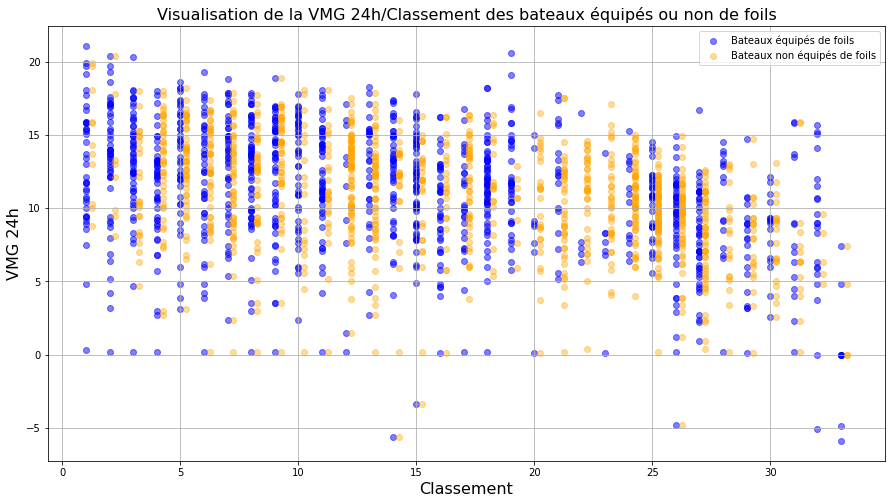

In [190]:
fig = plt.subplots(1, figsize=(15,8))

def compare_foil(num_df, nom_colonne_x, nom_colonne_y):
    classes_with_foils = dfz.loc[dfz['Foil']==1 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
    classes_without_foils = dfz.loc[dfz['Foil']==0 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
    print(sorted(classes_with_foils))
    print(sorted(classes_without_foils))

    NUM_PREMIER=1
    NUM_DERNIER=12
    CRITERE='VMG 24h'
    
    

    ax = plt.subplot(111)
    
    syx = dfz.loc[dfz['Classement final'].isin(classes_with_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Classement']]
    
    dim = len(syx['Classement'])
    w = 0.75
    dimw = w / dim
    
    ax.scatter(syx['Classement'], syx[CRITERE],\
               label="Bateaux équipés de foils", c='blue', marker='o', alpha=0.5)
    
    syx = dfz.loc[dfz['Classement final'].isin(classes_without_foils[NUM_PREMIER:NUM_DERNIER]), [CRITERE, 'Classement']]
    ax.scatter(syx['Classement'] + 0.25, syx[CRITERE],\
               label="Bateaux non équipés de foils", c='orange', marker='o', alpha=0.4)
    ax.grid()
    ax.legend()
    ax.set_title(f"Visualisation de la {nom_colonne_y}/{nom_colonne_x} des bateaux équipés ou non de foils", fontsize = 16)
    ax.set_xlabel(nom_colonne_x, fontsize = 16)
    ax.set_ylabel(nom_colonne_y, fontsize = 16)
#     fig.tight_layout()
#     ax.set_xticks(34 + 0.25 / 2)
    
    plt.show()

compare_foil(df, "Classement", "VMG 24h")

Poids et classement final

<AxesSubplot:xlabel='Poids', ylabel='Classement final'>

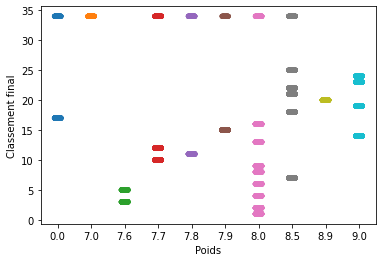

In [150]:
sns.stripplot(data=df, y='Classement final', x='Poids')


####################### san  inreret ##### 

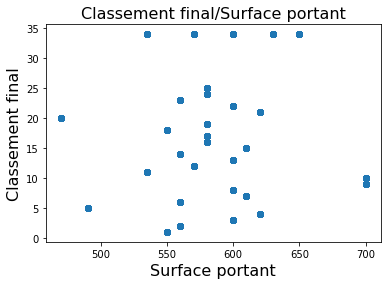

In [115]:
show_one_graph(num_df,  "Classement final", "Surface portant")


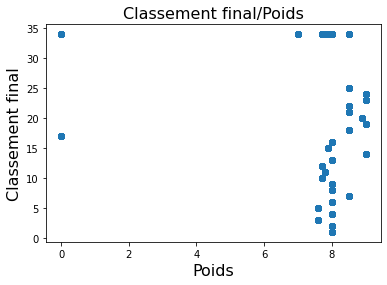

In [149]:
show_one_graph(num_df,  "Classement final", "Poids")


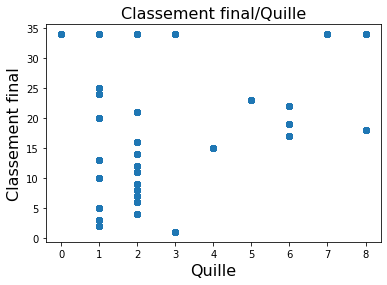

In [112]:
df['Année lancement']
show_one_graph(num_df,  "Classement final", "Quille")


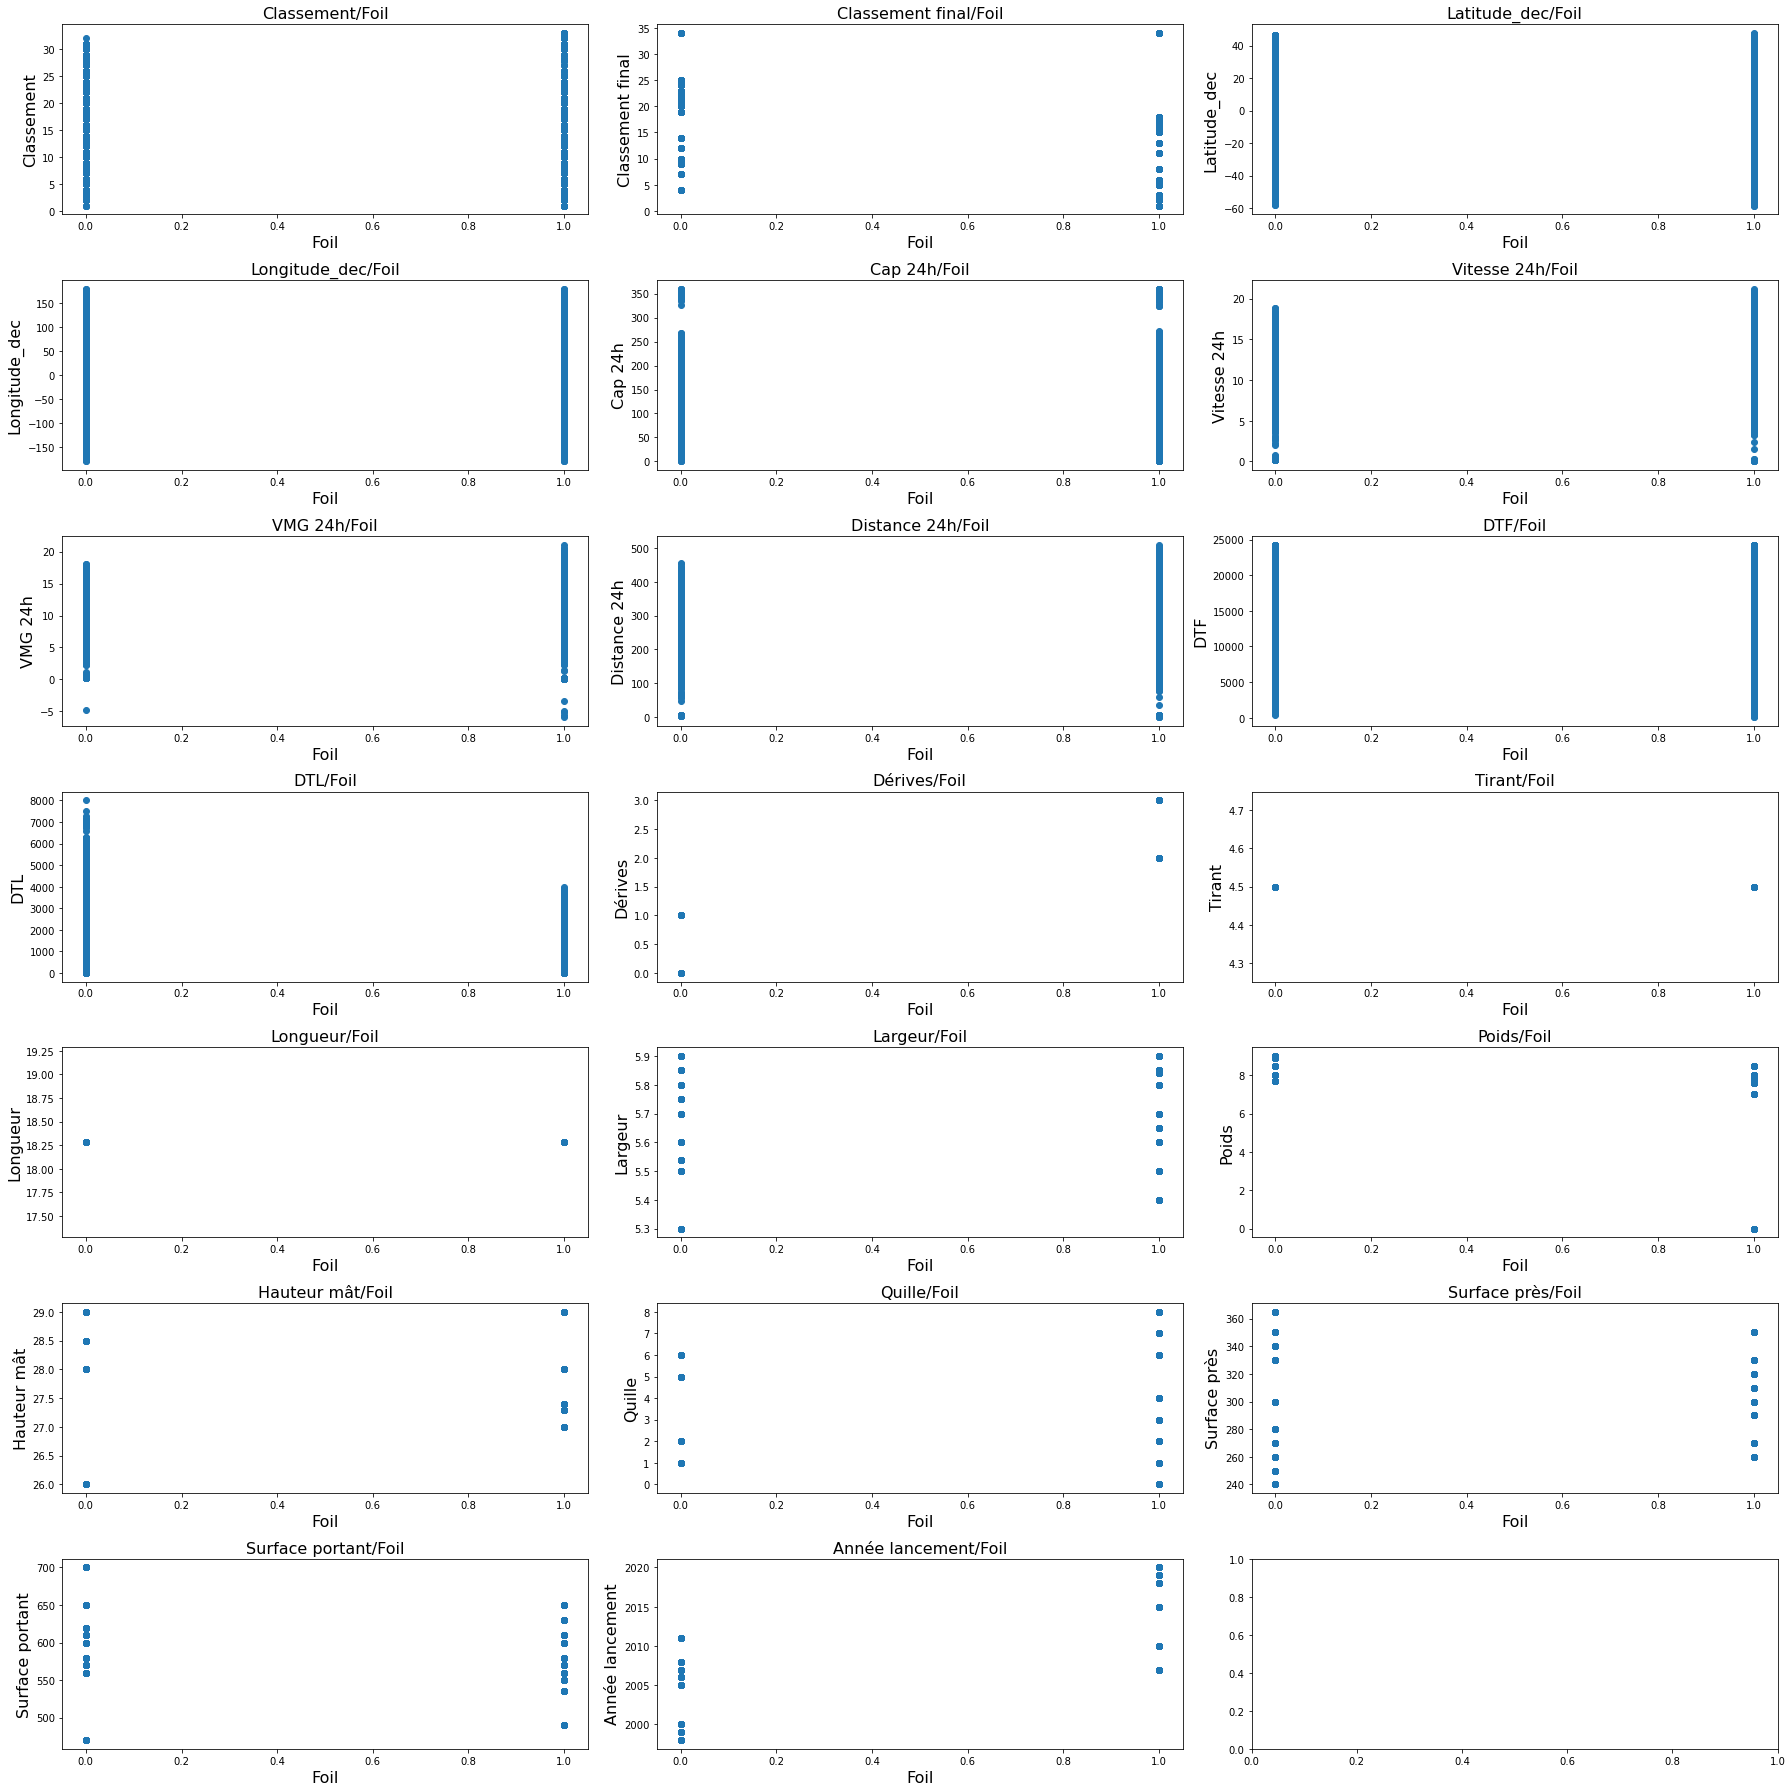

In [116]:
show_graphs(num_df, "Foil")

1 34
2302


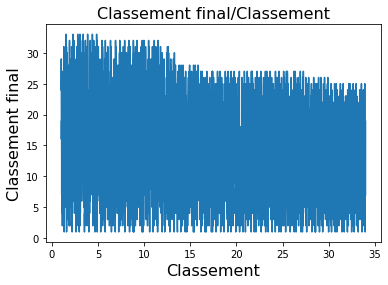

In [34]:
    
def show_plot_graph(num_df, nom_colonne_y, nom_colonne_x):
    Y = num_df[nom_colonne_y]
    X_cols=[nom_colonne_x]    
    X = num_df[X_cols]
    xmin = X.min()[0]
    xmax = X.max()[0]
    print(xmin, xmax)
    print(len(Y))
    xabs = np.linspace(xmin, xmax, len(Y))
    ax = plt.subplot(111)
    ax.plot(xabs, Y)
    ax.set_title(nom_colonne_x + "/" + nom_colonne_y , fontsize = 16)
    ax.set_xlabel(nom_colonne_y, fontsize = 16)
    ax.set_ylabel(nom_colonne_x, fontsize = 16)
#     fig.tight_layout()
    plt.show()
    
show_plot_graph(num_df,  "Classement", "Classement final")

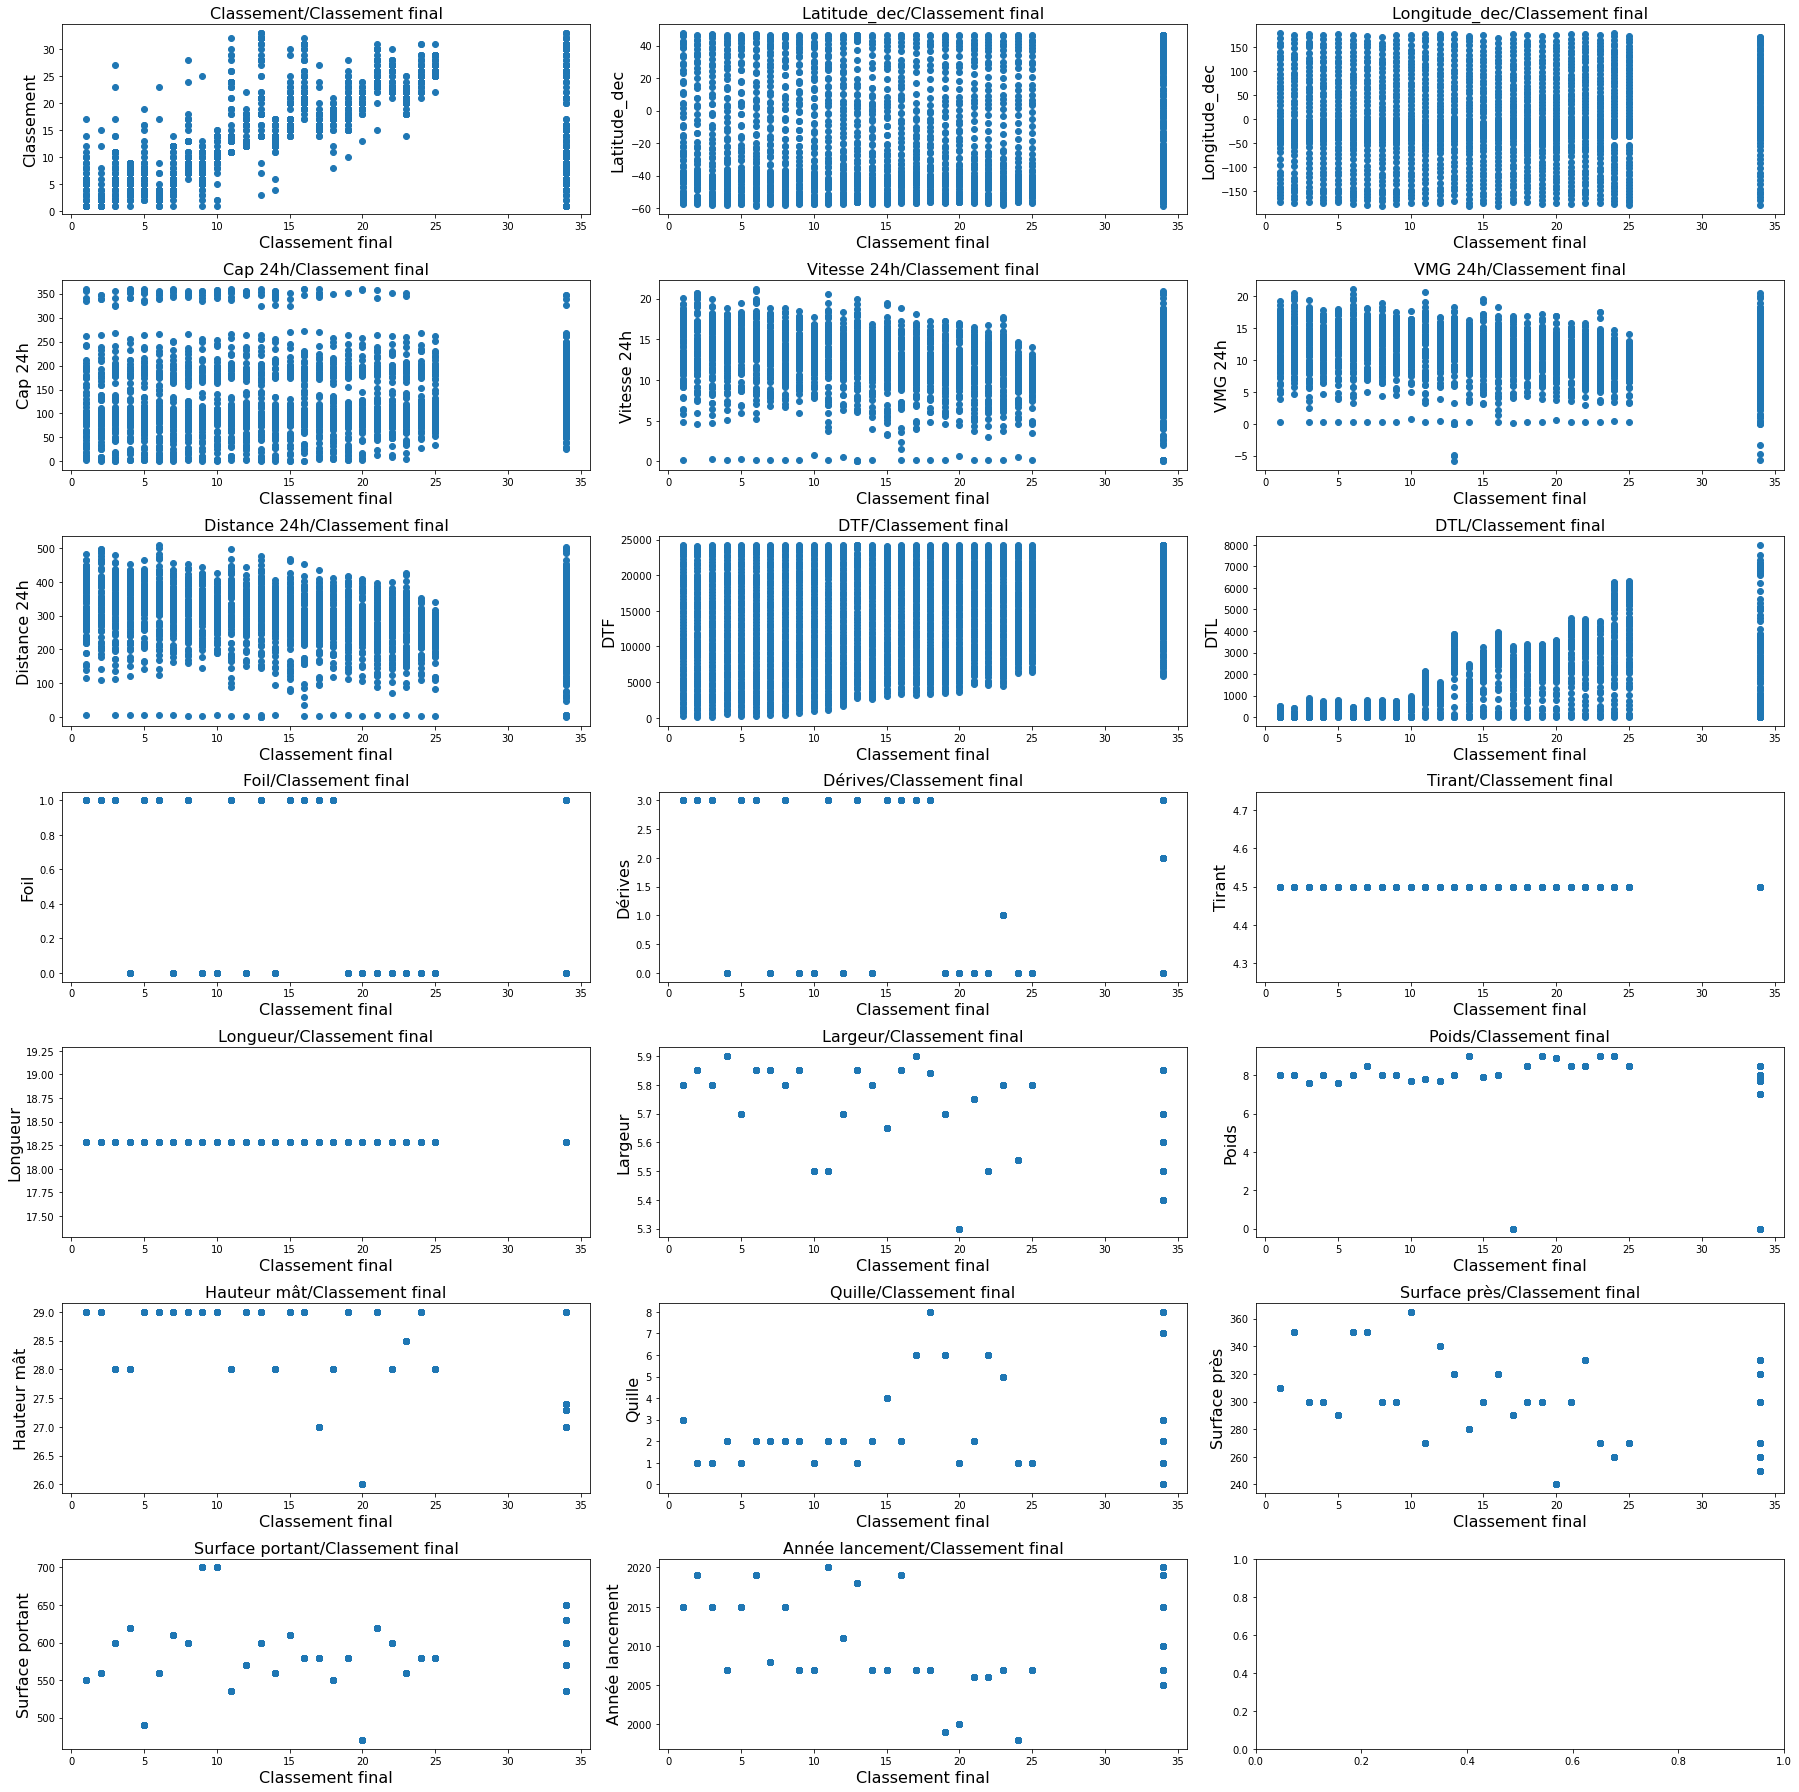

In [35]:
show_graphs(num_df, nom_colonne_y)

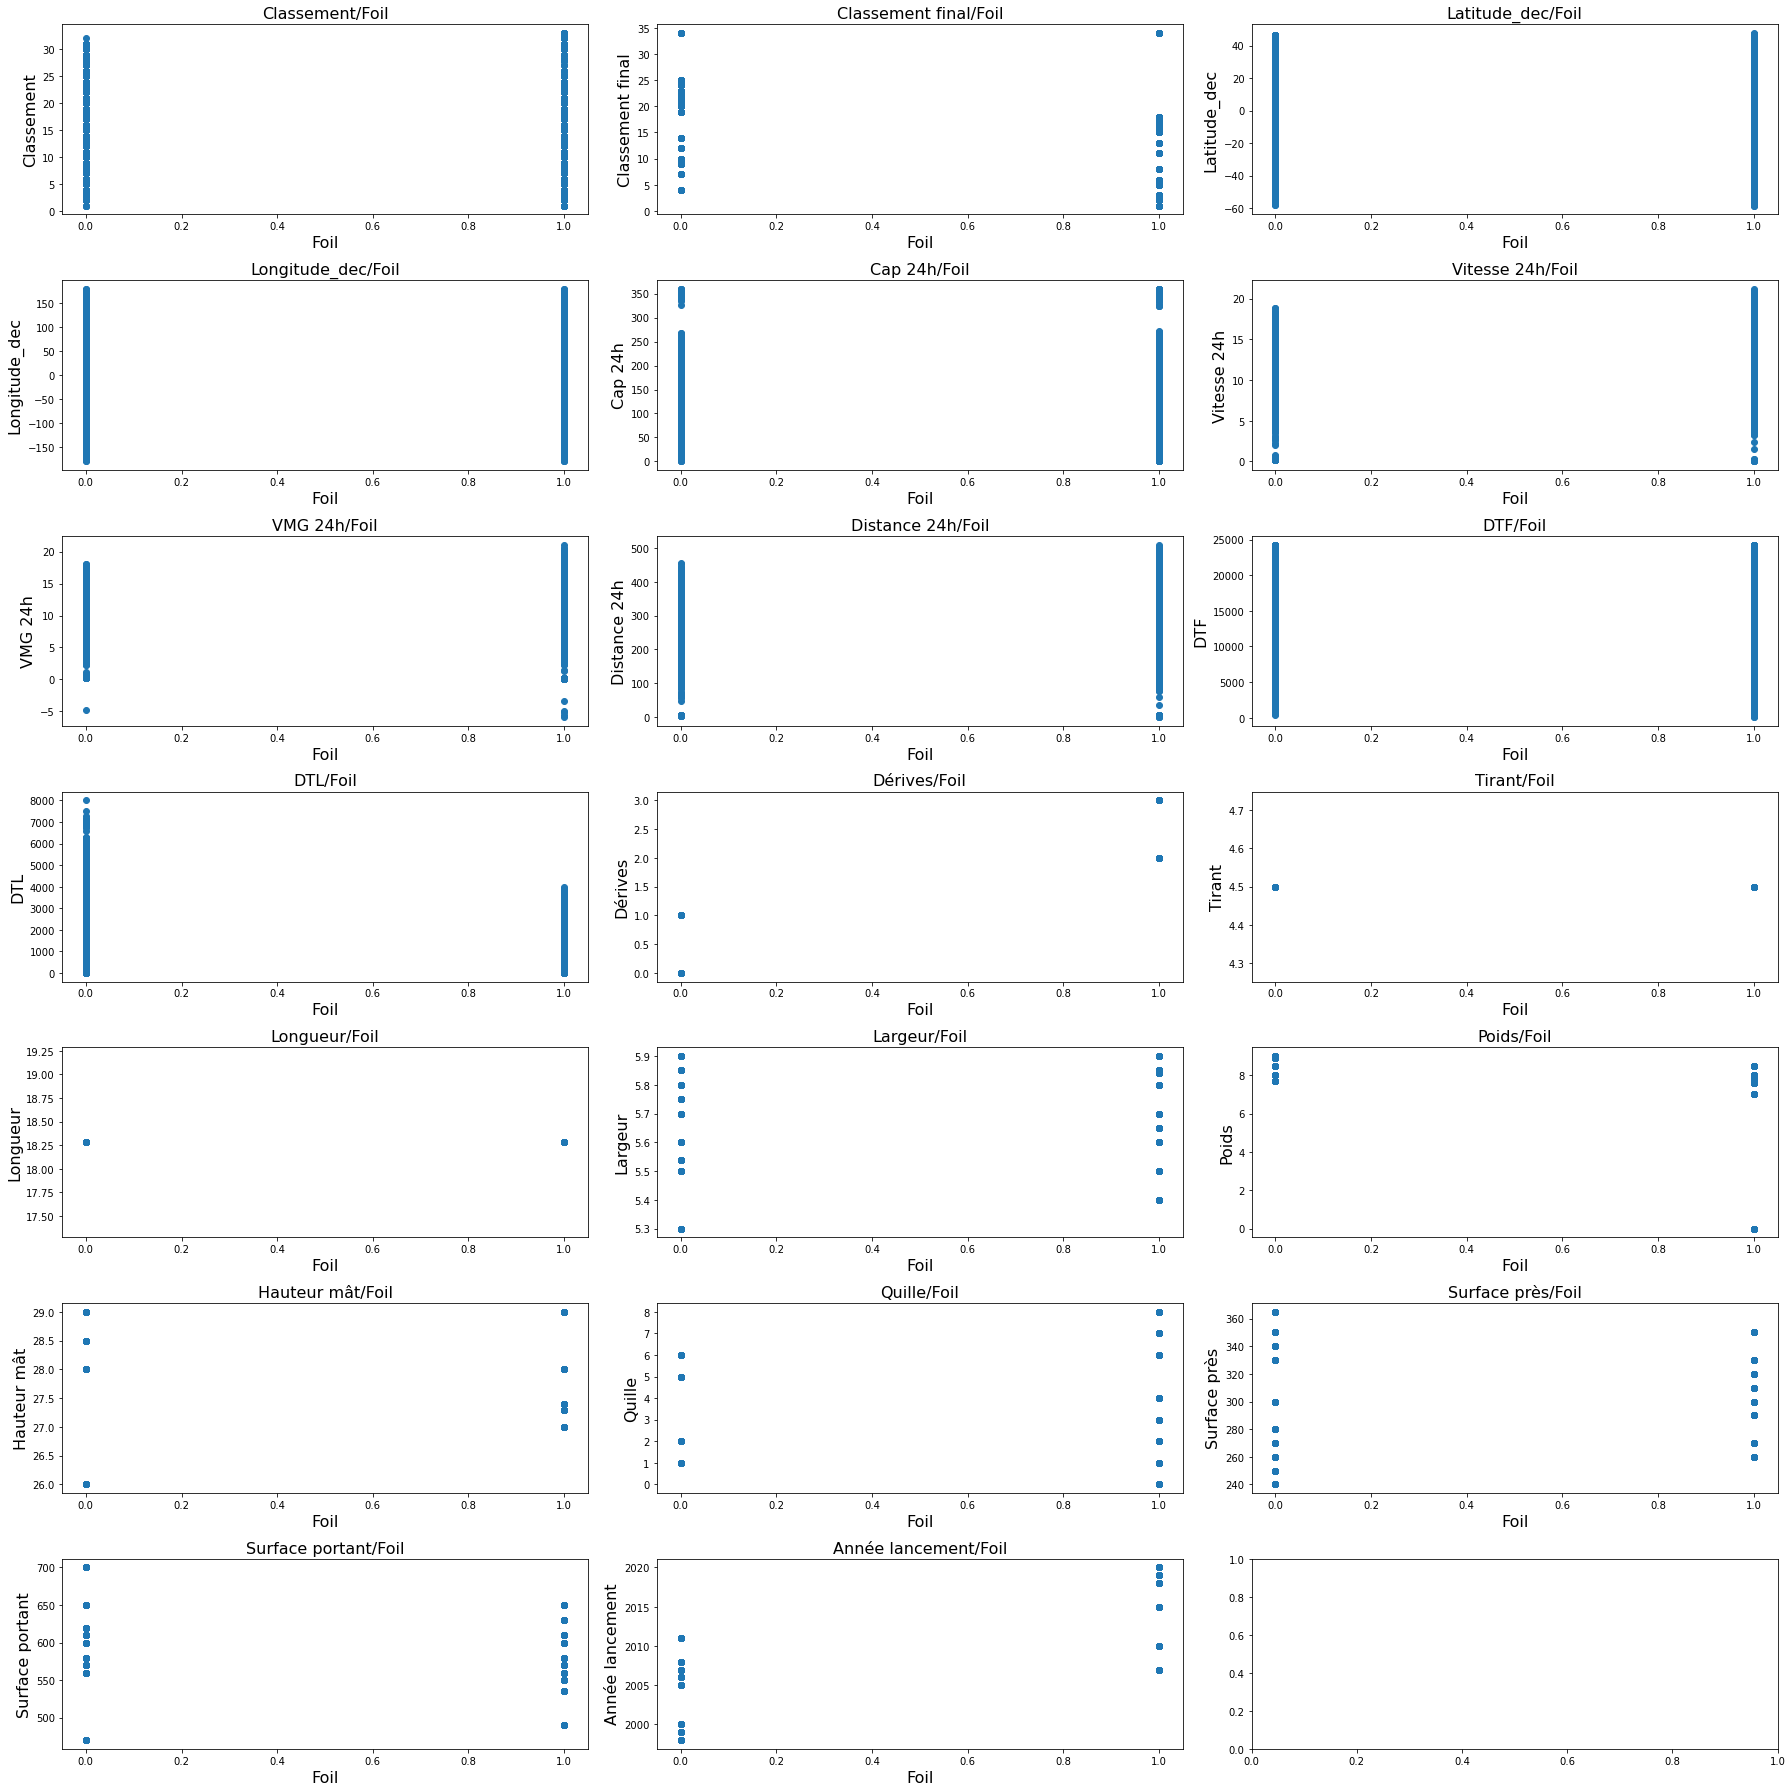

In [36]:
show_graphs(num_df, "Foil")

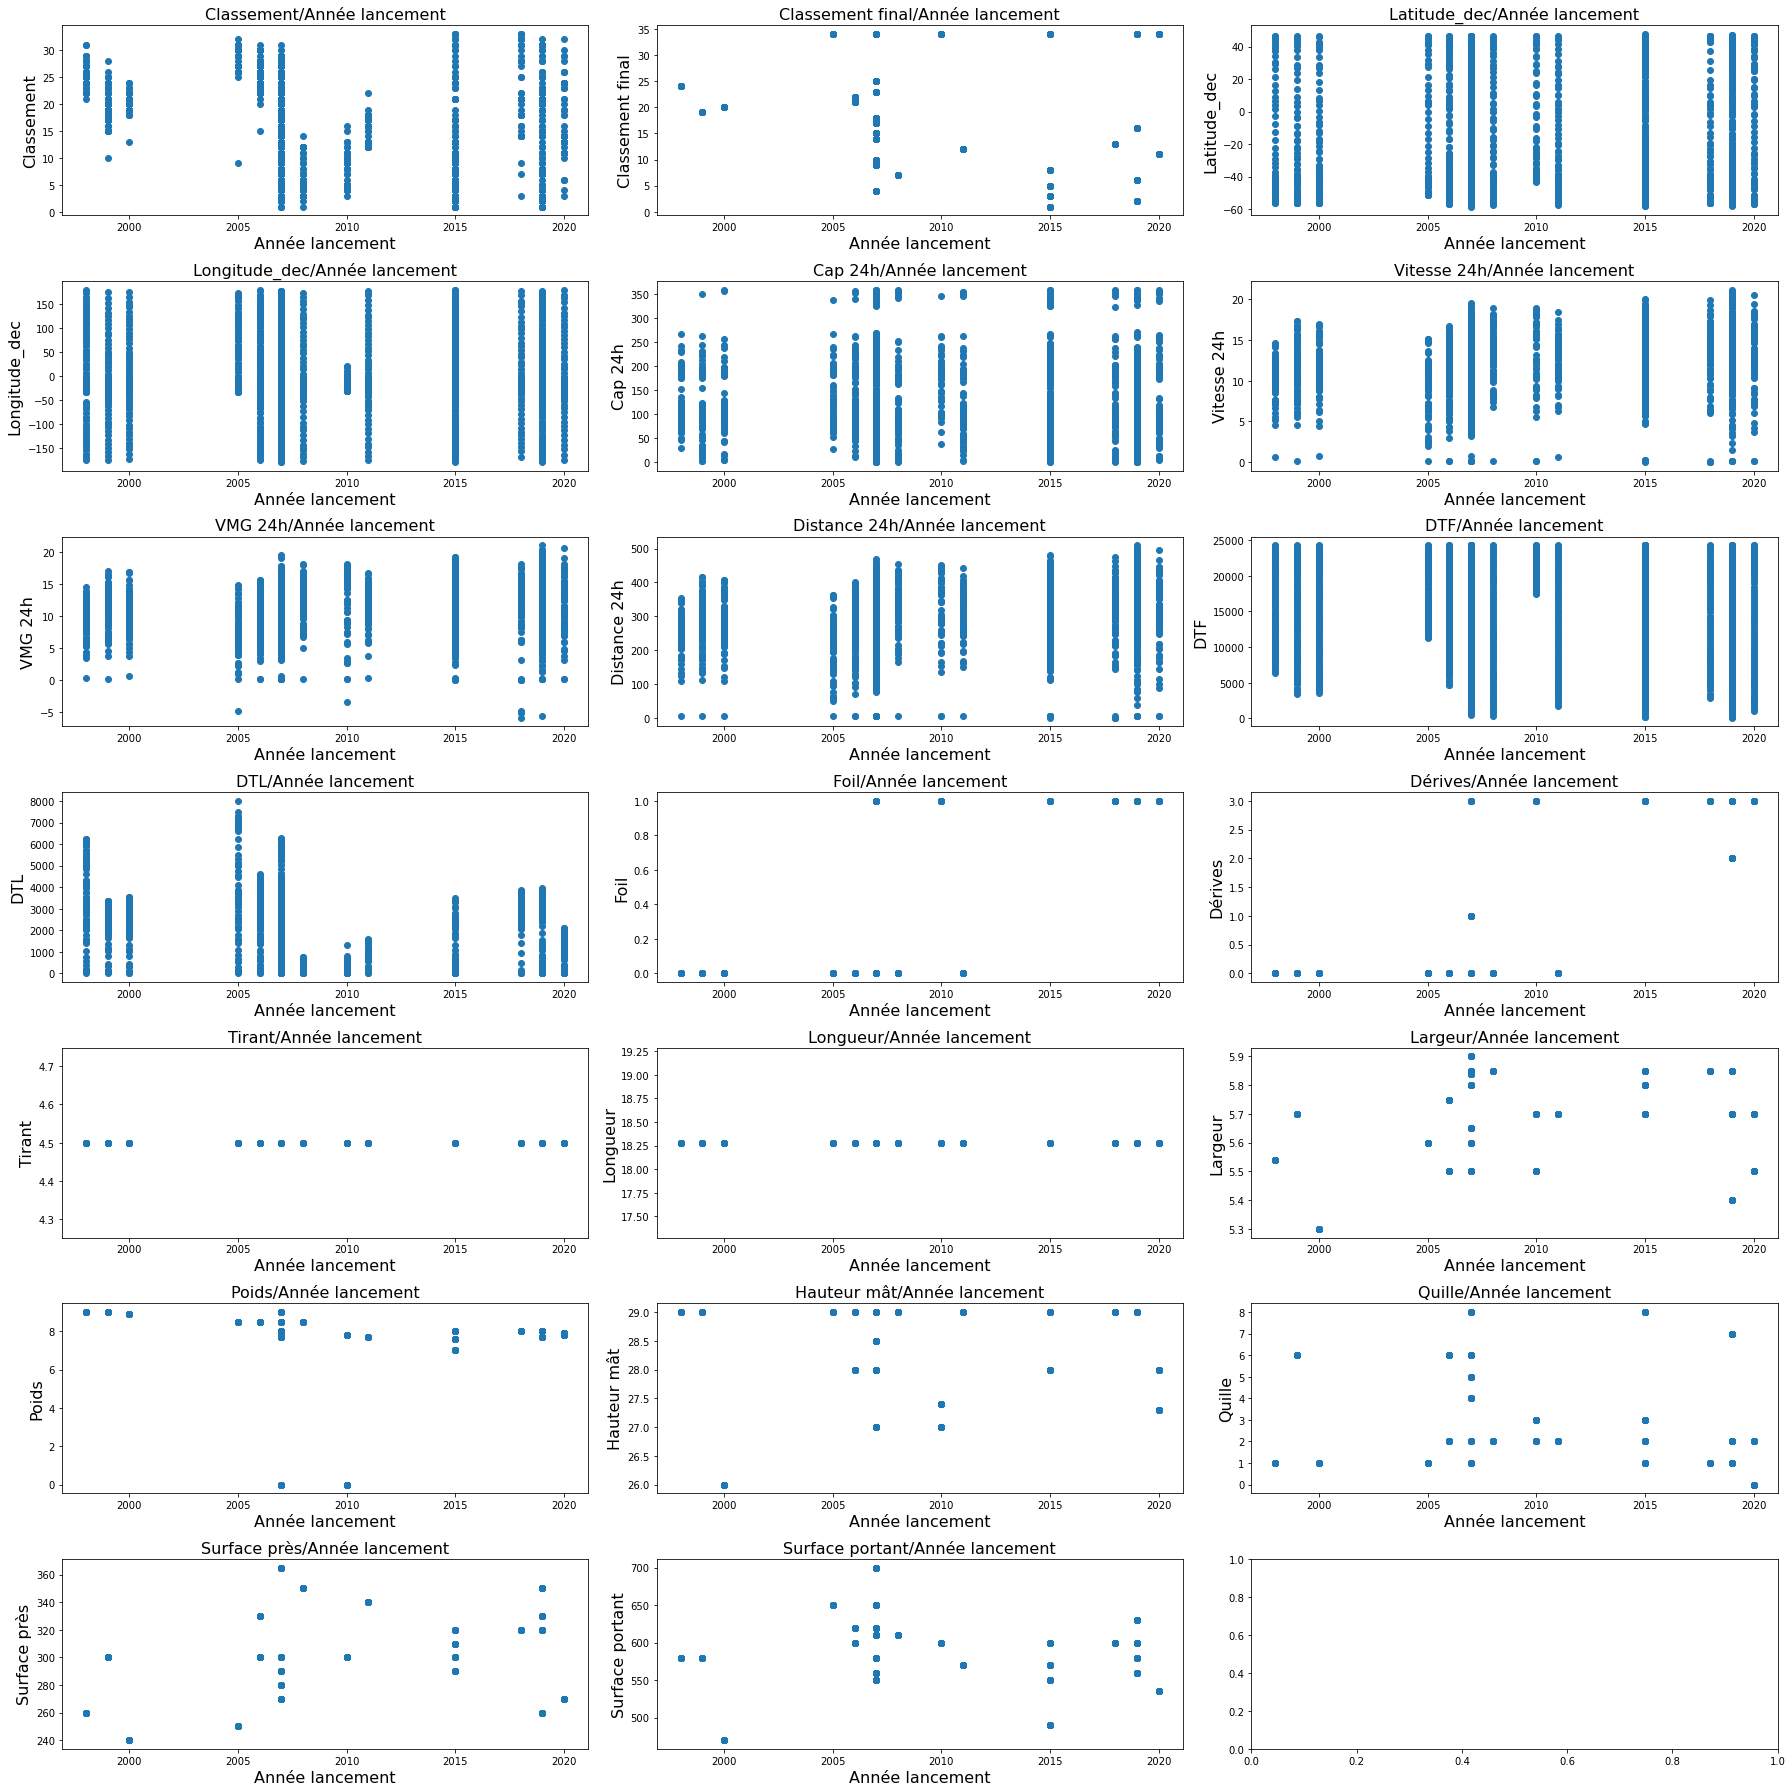

In [37]:
show_graphs(num_df, "Année lancement")

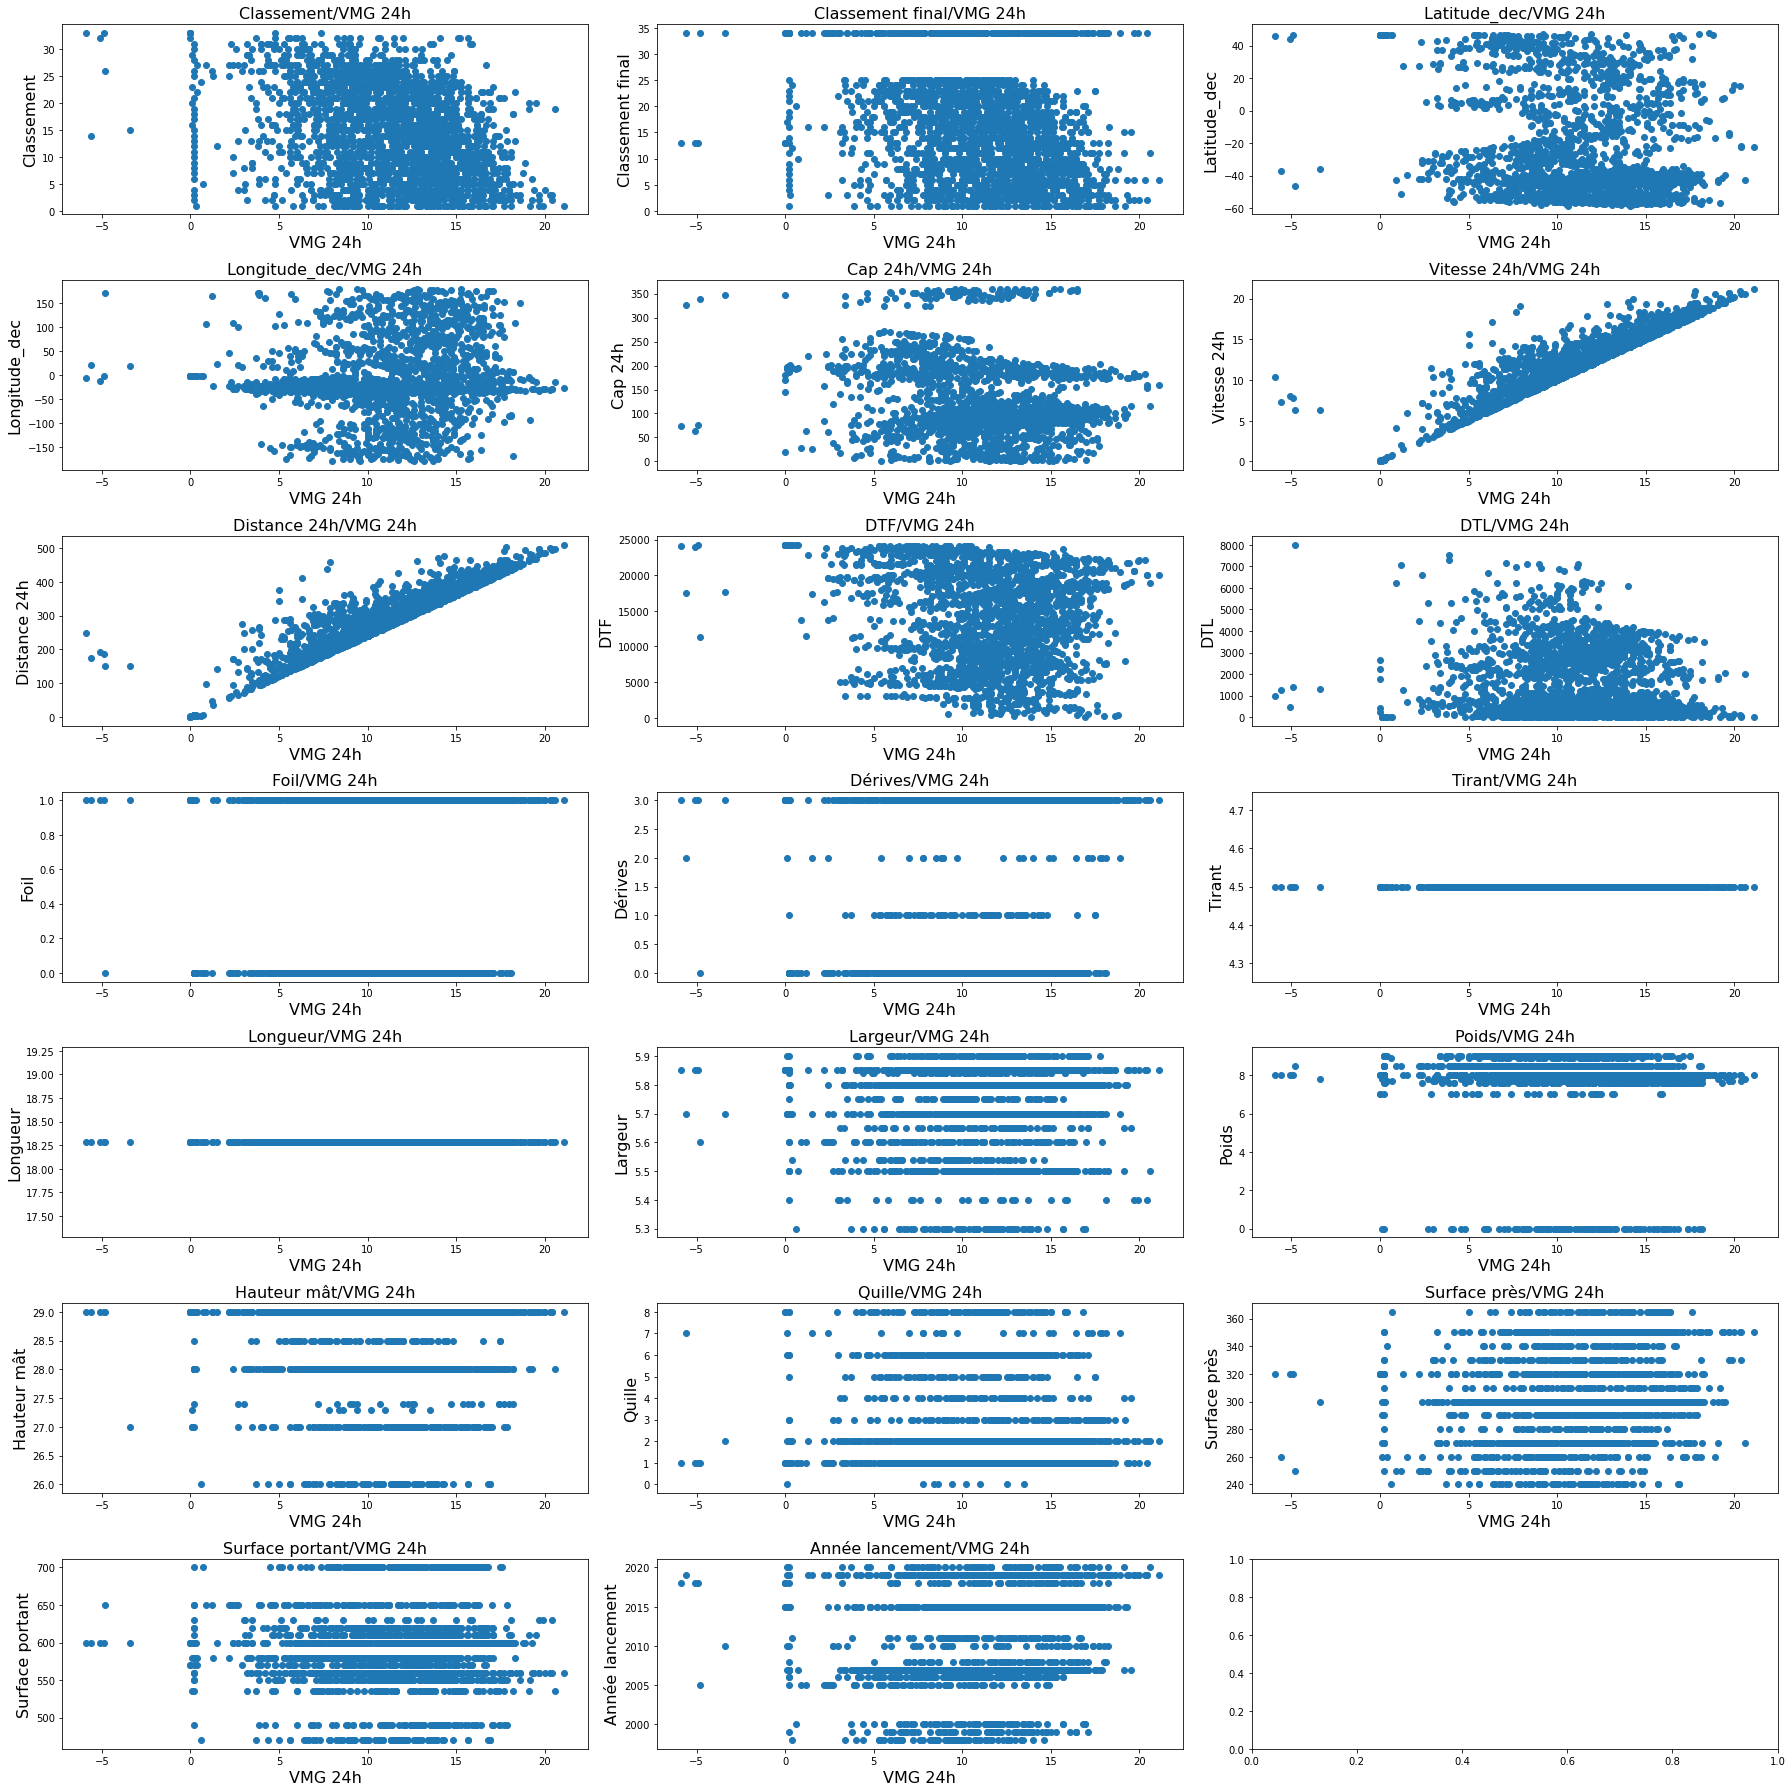

In [38]:
show_graphs(num_df, "VMG 24h")

In [39]:
# for col in num_df.columns:
#     if col != 'Classement final':
#         plt.figure(figsize=(5, 4), dpi=80)

#         # On trace
#         plt.scatter(Y, X[col])
#         # On légende
#         plt.title(col + "/Classement final" , fontsize = 14)
#         plt.xlabel("Classement final", fontsize=12)
#         plt.ylabel(col, fontsize=12)


In [40]:
# dfz.loc[dfz['Foil']==1, 'Skipper'].unique()

In [41]:
# dfz.loc[dfz['Foil']==0 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique()

[1, 2, 3, 5, 6, 8, 11, 13, 15, 16, 17, 18, 25, 34]
[4, 7, 9, 10, 12, 14, 19, 20, 21, 22, 23, 24, 25, 34]
6
5
4
23


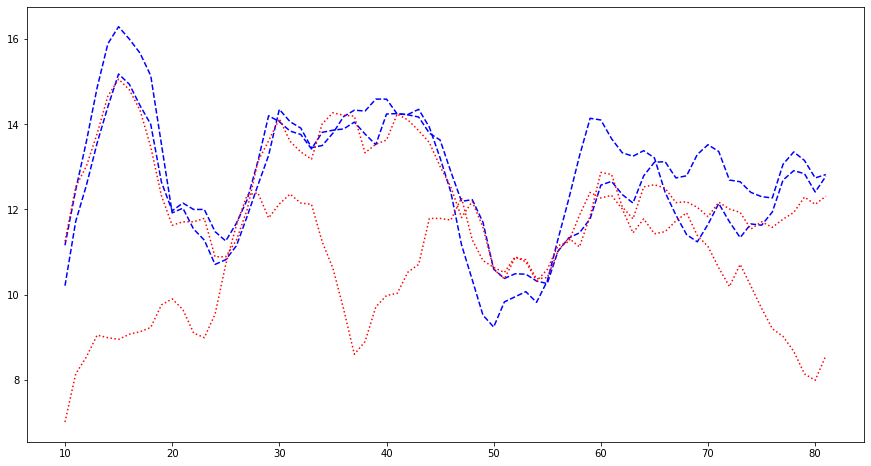

In [43]:
# remove nan lines
# extract pour chaque bateau la vitesse / 24 en histogramme
# correlation vitesse distance
# 
fig = plt.subplots(1, figsize=(15,8))


classes_with_foils = dfz.loc[dfz['Foil']==1 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
classes_without_foils = dfz.loc[dfz['Foil']==0 & dfz['Classement final'].isin(range(1,25)), 'Classement final'].unique().tolist()
print(sorted(classes_with_foils))
print(sorted(classes_without_foils))

ROLLING=10
NUM_PREMIER=1
NUM_DERNIER=3
CRITERE='VMG 24h'

for i  in classes_with_foils[NUM_PREMIER:NUM_DERNIER]:
    print(i)
#     skipper = dfz.loc[, 'Skipper'].unique().tolist()
    sw = dfz.loc[dfz['Classement final']==i, [CRITERE]]
    sw = sw.rolling(ROLLING).mean()
    xabs=np.linspace(1, len(sw), len(sw))
    plt.plot(xabs, sw, "b--")

for i  in classes_without_foils[NUM_PREMIER:NUM_DERNIER]:
    print(i)
#     skipper = dfz.loc[dfz['Classement final']==i, 'Skipper'].unique().tolist()
    swo = dfz.loc[dfz['Classement final']==i, [CRITERE]]
    swo = swo.rolling(ROLLING).mean()
    xabs=np.linspace(1, len(swo), len(swo))
    plt.plot(xabs, swo, 'r:')
    


In [44]:
# # seaborn histogram
# sns.distplot(sw, hist=True, kde=False, 
#              bins=len(swo), color = 'blue',
#              hist_kws={'edgecolor':'black'})
# # seaborn histogram
# sns.distplot(swo, hist=True, kde=False, 
#              bins=len(swo), color = 'red',
#              hist_kws={'edgecolor':'black'})



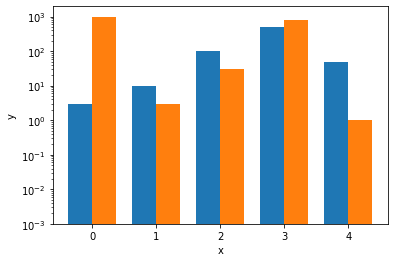

In [47]:
import matplotlib.pyplot as plt
import numpy as np

data = ((3, 1000), (10, 3), (100, 30), (500, 800), (50, 1))

dim = len(data[0])
w = 0.75
dimw = w / dim

fig, ax = plt.subplots()
x = np.arange(len(data))
for i in range(len(data[0])):
    y = [d[i] for d in data]
    b = ax.bar(x + i * dimw, y, dimw, bottom=0.001)

ax.set_xticks(x + dimw / 2)
ax.set_xticklabels(map(str, x))
ax.set_yscale('log')

ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()

In [48]:
# s = dfz.loc[dfz['Classement final'].isin(classes_with_foils[1:4]), ['VMG dernier', 'Fichier de resultats']]
# s.groupby('Fichier de resultats').sum()


PLOT PAR SKIPPERS

['Jean Le Cam' 'Louis Burton' 'Yannick Bestaven' 'Charlie Dalin']


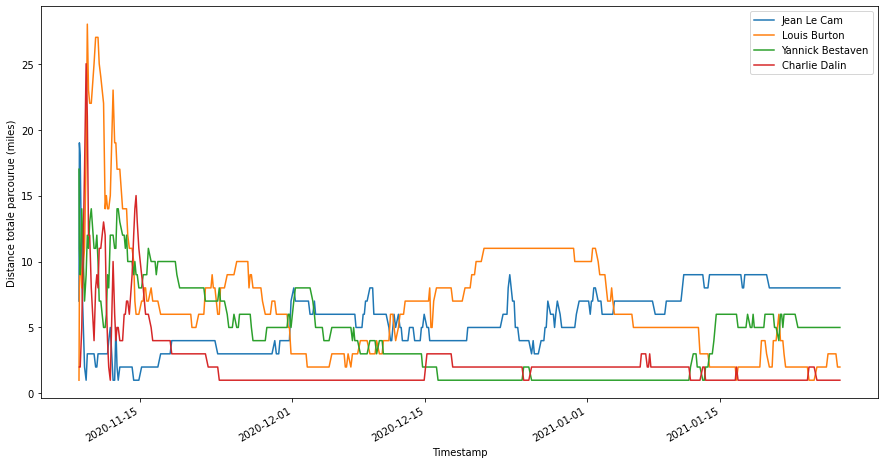

In [49]:
fig = plt.subplots(1, figsize=(15,8))

skips = df.loc[df['Classement final'].isin(range(1,5)), "Skipper"].unique()

print(skips)
for skipper in skips:
    skip = df.loc[(df['Skipper'] == skipper),"Classement"]
    skip.plot(label = skipper)

plt.ylabel('Distance totale parcourue (miles)')
plt.legend();

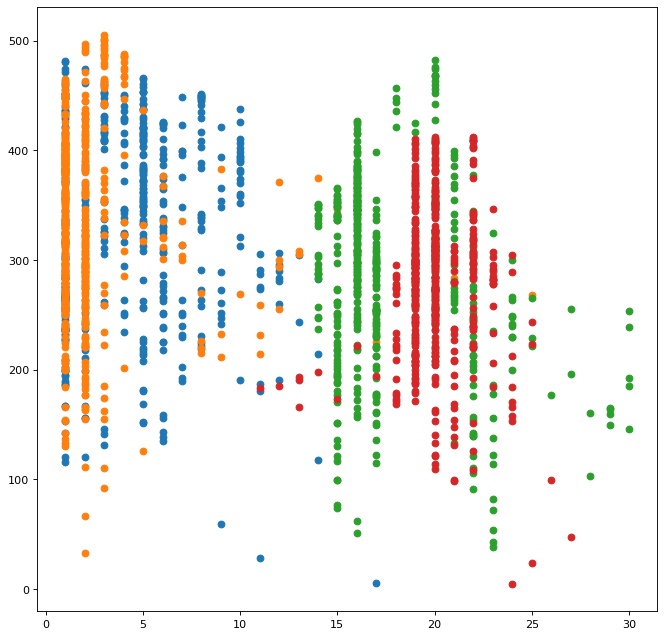

In [50]:
# 
fig, ax = plt.subplots(1, 1, figsize=(10, 10), dpi=80)

for i in [1, 2, 15, 20]:
    s = df.loc[df['Classement final']==i]
    X = s['Classement']
    Y = s['Distance 24h']
    x = np.linspace(0, len(s)/4, len(s))
    ax.scatter(X, Y)

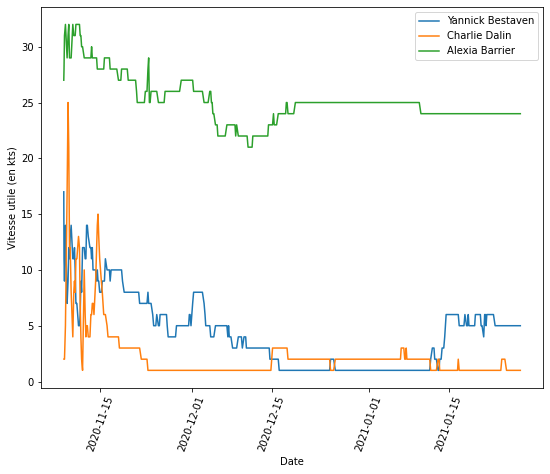

In [51]:
skippers = ['Yannick Bestaven', 'Charlie Dalin', 'Alexia Barrier']

def time_series(df, skippers):
    CRITERE="Classement"
    df_run = df[['Skipper', CRITERE]] 
    
    plt.figure(2, figsize=(9, 7))
    
    for skipper in skippers:
        df_skipper = df_run.loc[df_run['Skipper'] == skipper, [CRITERE]]
        plt.plot(df_skipper[CRITERE], label=skipper) 
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('Vitesse utile (en kts)')
    plt.legend(loc='upper right')
    plt.plot()
    

time_series(df, skippers)    
    

['Sébastien Simon', 'Samantha Davies', 'Alex Thomson', 'Fabrice Amedeo', 'Nicolas Troussel', 'Sébastien Destremau', 'Kevin Escoffier', 'Isabelle Joschke']


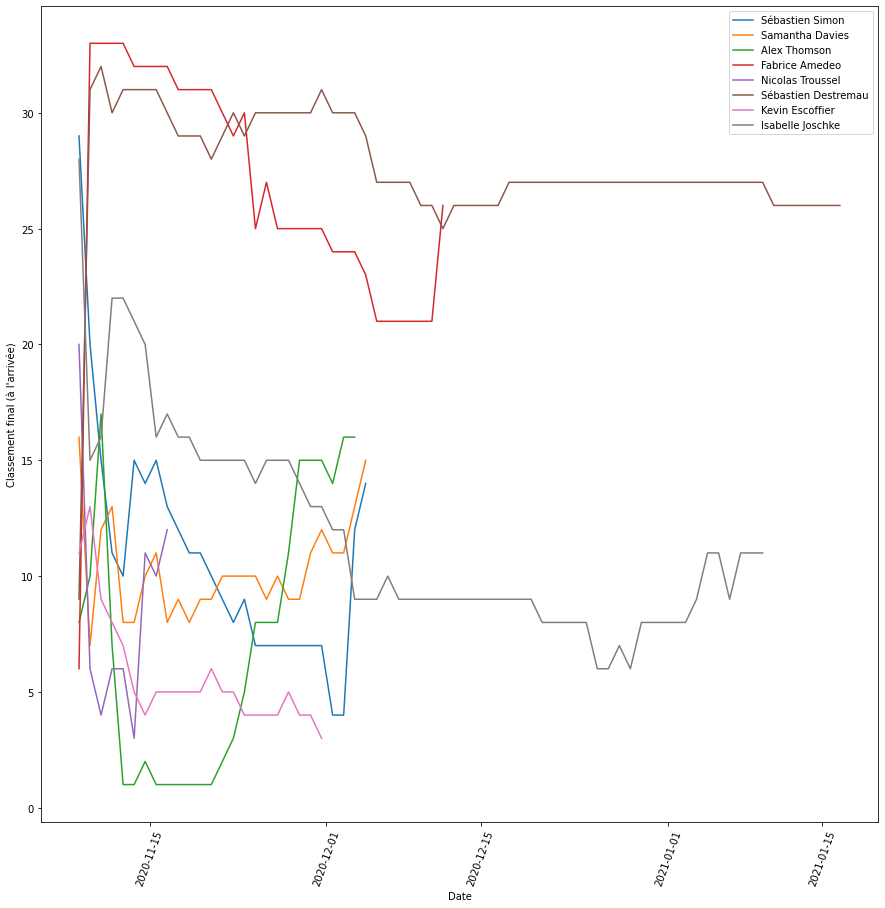

In [52]:
skippers_abandon = df.loc[df['Classement final']==34, 'Skipper'].unique().tolist()
print(skippers_abandon)
def time_series(df, skippers):
    CRITERE="Classement"
    df_run = df[['Skipper', CRITERE]] 
    
    plt.figure(2, figsize=(15,  15))
    
    for skipper in skippers:
        df_skipper = df_run.loc[df_run['Skipper'] == skipper, [CRITERE]]
        plt.plot( df_skipper[CRITERE], label=skipper) 
    
    plt.xticks(rotation=70)
    plt.xlabel('Date')
    plt.ylabel('Classement final (à l\'arrivée)')
    plt.legend(loc='upper right')
    plt.plot()
    

time_series(dfz, skippers_abandon)    
    

Yannick Bestaven et Charlie Dalin, tous deux en tête du classement, ont des performances semblables en terme de vitesse utile tout au long de la série temporelle.
Aliexia Barrier, en fin de classement, a été presque constamment en dessous de leurs vitesses utile ce qui a très certainement joué un impact dans son rang.

In [53]:
Skippers = ['Charlie Dalin', 'Louis Burton', 'Boris Herrmann', 'Thomas Ruyant', 'Yannick Bestaven']

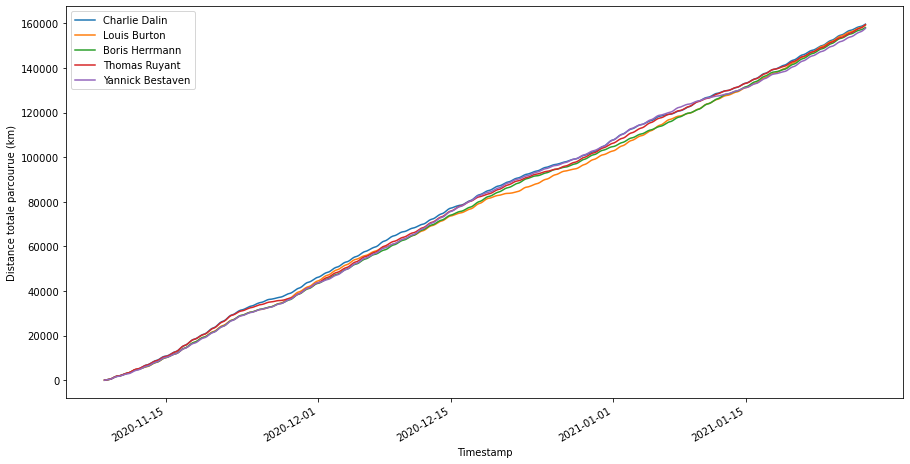

In [54]:
fig = plt.subplots(1, figsize=(15,8))

for skipper in Skippers[:5]:
    skip = df.loc[(df['Skipper'] == skipper), "Distance 24h"]
    skip.cumsum().plot(label = skipper)

plt.ylabel('Distance totale parcourue (km)')
plt.legend();

## Cartogtaphie

In [55]:
sorted(dfsk["Longitude_dec"])

NameError: name 'dfsk' is not defined

In [ ]:
dflong = df.loc[df["Longitude_dec"]<=0, 'Longitude_dec'].apply(lambda x: x+270)
dflong

In [ ]:
df[['Skipper','Classement final']].sort_values(by='Classement final')

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(go.Scattermapbox())
skippers=df.loc[df['Classement final'].isin(range(1,25)), "Skipper"].unique().tolist()

skippers=[]
for k in range(1, 26):
    skip = df.loc[df['Classement final']==k, 'Skipper' ].unique().tolist()
    skippers.append(skip[0])

print(skippers,order)
for i, skipper in enumerate(skippers[0:5]): 
    dfsk = df.loc[df['Skipper'] == skipper]
    stamp = dfsk.index

    fig.add_trace(go.Scattermapbox(
        visible=True,
        mode = "markers+text+lines",
        lon = dfsk["Longitude_dec"].round(5),
        lat = dfsk["Latitude_dec"].round(5),
        name = skipper,
        marker = {'size': 3},
                text= stamp ))
    i+=1
     

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        
        'center': {'lon': 0, 'lat': 0},
        'style': "stamen-watercolor",
        'center': {'lon': 0, 'lat': 0},
        'zoom': 0.6})

fig.show()

TODO: fix line on map https://community.plotly.com/t/plotly-scattermapbox-positive-to-negative-longitudes/37748/2

In [ ]:
import plotly.graph_objects as go

# token = open(".mapbox_token").read() # you need your own token

fig = go.Figure(go.Scattermapbox(
    mode = "markers+text+lines",
    lon = [-75, -80, -50], lat = [45, 20, -20],
    marker = {'size': 20, 'symbol': ["bus", "harbor", "airport"]},
    text = ["Bus", "Harbor", "airport"],textposition = "bottom right"))

fig.update_layout(
    mapbox = {
#         'accesstoken': token,
        'style': "outdoors", 'zoom': 0.7},
    showlegend = False)

fig.show()

In [ ]:
df['Fichier de resultats'].apply(lambda x: x.split('_')[1])=="080000"

# 
fig, ax = plt.subplots(1,1)
for i in [1, 20]:
    s = df.loc[df['Classement final']==i & df['Fichier de resultats'].apply(lambda x: x.split('_')[1])=="080000"]
    pass
#     print(s2)
#     X = s2['Classement']
#     Y = s2['Distance 24h']
    
#     x = np.linspace(0, len(s)/4, len(s))
#     ax.plot(x, Y)

    

In [ ]:
# 
fig, ax = plt.subplots(1,1)

for i in range(0, 2):
    s = num_df.loc[num_df['Classement']==i]
    X = s['Foil']
    Y = s['VMG 24h']
    
    xxbar = (X - X.mean())
    covX = xxbar@xxbar.T
    print(covX)
    covXY = xxbar@(Y - Y.mean())
    print(covXY)
    x = np.linspace(0, len(s), len(s))
    ax.plot(Y, x)
    
num_df["VMG 24h"].min()

In [ ]:
# ### https://cedric.cnam.fr/vertigo/Cours/ml/tpAcp.html ### #

import numpy as np
# Génération de données selon une loi normale tridimensionnelle
rndn3d = np.random.randn(500,3)
#rndn3d = np.array([ num_df["Foil"].to_list(), num_df["VMG 24h"].to_list(), num_df["Classement final"].to_list() ])

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Affichage du nuage de points
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rndn3d[:,0], rndn3d[:,1], rndn3d[:,2])
plt.title("Données initiales")
plt.show()

# 
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca.fit(rndn3d)

print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_)
print("Composantes principales : ")
print(pca.components_)

#
s1 = np.array([[3,0,0],[0,1,0],[0,0,0.2]])  # matrice de déformation
r1 = np.array([[0.36,0.48,-0.8],[-0.8,0.6,0],[0.48,0.64,0.6]])  # matrice de rotation
rndef = rndn3d.dot(s1).dot(r1)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(rndef[:,0], rndef[:,1], rndef[:,2])
plt.title("Données déformées")
plt.show()


# 
pca = PCA(n_components=3)
pca.fit(rndef)

print("Pourcentage de variance expliquée : ")
print(pca.explained_variance_ratio_)
print("Composantes principales : ")
print(pca.components_)

In [ ]:
%matplotlib notebook


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111, projection='3d')
LABEL_FONT_SIZE=15

for i in zip(range(1, 10)):
    CRITERE_X = 'Classement'
    CRITERE_Y = 'Foil'
    CRITERE_Z = 'VMG 24h'
    x2 = df.loc[df['Classement final']==i, CRITERE_Y]
    x3 = df.loc[df['Classement final']==i, CRITERE_Z] 
    x1 = df.loc[df['Classement final']==i, CRITERE_X]
    
    ax.scatter(x1, x2, x3)
    ax.set_xlabel(CRITERE_X, fontsize=LABEL_FONT_SIZE, rotation=150)
    ax.set_ylabel(CRITERE_Y, fontsize=LABEL_FONT_SIZE, rotation=150)
    ax.set_zlabel(CRITERE_Z, fontsize=LABEL_FONT_SIZE, rotation=60)
    
    ax.yaxis._axinfo['label']['space_factor'] = 3.0



fig.tight_layout()
plt.show()

# fig, axes = plt.subplots(ncols=2, nrows=6, figsize=(25 , 25))

# for idx, idcl in enumerate([1, 2, 15, 20]):
# #     ax = fig.add_subplot(111, projection='3d')

#     x2 = df.loc[df['Classement final']==idcl, 'Classement final']
#     x3 = df.loc[df['Classement final']==idcl, 'Distance 24h'] 
#     x1 = df.loc[df['Classement final']==idcl, 'Classement']
    
#     ax[idx].remove()
#     ax[idx] = fig.add_subplot(111,  projection='3d')
#     ax.scatter(x1, x2, x3)
    
    

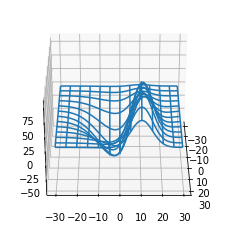

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [88]:
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# load some test data for demonstration and plot a wireframe
X, Y, Z = axes3d.get_test_data(0.1)
ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

# rotate the axes and update
for angle in range(0, 360):
    ax.view_init(30, angle)
    plt.draw()
    plt.pause(.001)
    


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)

for i in zip([1, 2, 15, 20, 25]):
    var = df.loc[df['Classement final'].isin([1, 5, 10, 15, 20, 25]) & df['Foil'].isin([1, 0])]

    #     x2 = df.loc[df['Classement final']==i, 'Classement final']
    x3 = df.loc[df['Classement final']==i, 'Distance 30m'] 
    x1 = df.loc[df['Classement final']==i, 'Classement']

    ax.scatter(x1, x3)

fig.tight_layout()
plt.show()

# fig, axes = plt.subplots(ncols=2, nrows=6, figsize=(25 , 25))

# for idx, idcl in enumerate([1, 2, 15, 20]):
# #     ax = fig.add_subplot(111, projection='3d')

#     x2 = df.loc[df['Classement final']==idcl, 'Classement final']
#     x3 = df.loc[df['Classement final']==idcl, 'Distance 24h'] 
#     x1 = df.loc[df['Classement final']==idcl, 'Classement']
    
#     ax[idx].remove()
#     ax[idx] = fig.add_subplot(111,  projection='3d')
#     ax.scatter(x1, x2, x3)
    
    

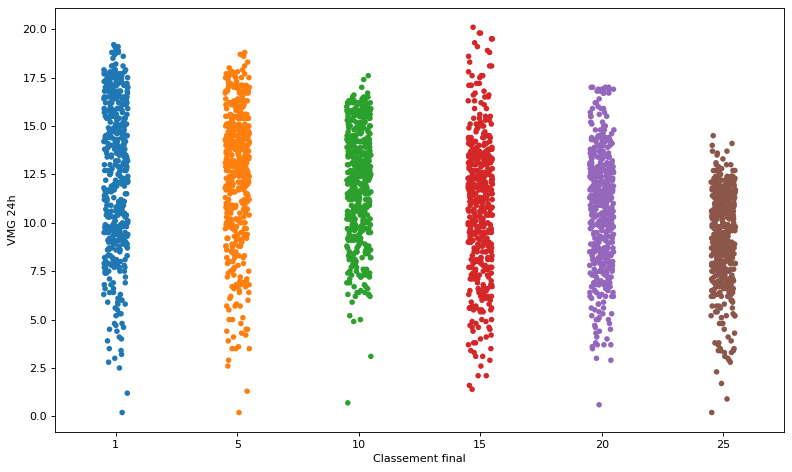

In [89]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure(figsize=(10, 6), dpi=80)
ax = fig.add_subplot(111)

# for i in [1, 2, 15]:

#     x2 = df.loc[df['Classement final']==i, 'Classement final']
#     x3 = df.loc[df['Classement final']==i, 'Distance 30m'] 
#     x1 = df.loc[df['Classement final']==i, 'Classement']
    
#     ax.scatter(x1, x3)
    # stripplot horizontal
#     df['terminal'] = df['name'].str[-1].str.upper()
var = df.loc[df['Classement final'].isin([1, 5, 10, 15, 20, 25]) & df['Foil'].isin([1, 0])]


fig.tight_layout()
plt.show()

# fig, axes = plt.subplots(ncols=2, nrows=6, figsize=(25 , 25))

# for idx, idcl in enumerate([1, 2, 15, 20]):
# #     ax = fig.add_subplot(111, projection='3d')

#     x2 = df.loc[df['Classement final']==idcl, 'Classement final']
#     x3 = df.loc[df['Classement final']==idcl, 'Distance 24h'] 
#     x1 = df.loc[df['Classement final']==idcl, 'Classement']
    
#     ax[idx].remove()
#     ax[idx] = fig.add_subplot(111,  projection='3d')
#     ax.scatter(x1, x2, x3)
    
    

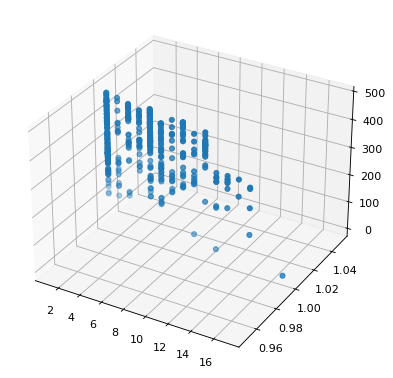

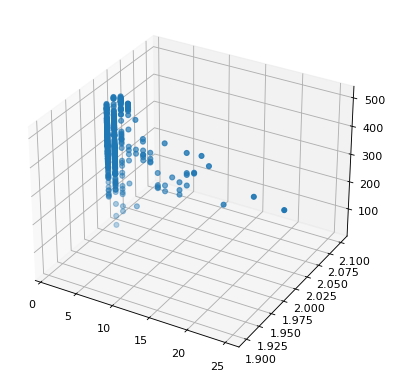

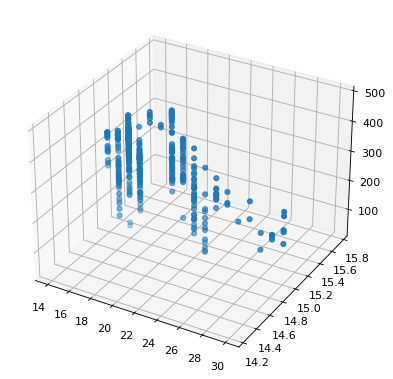

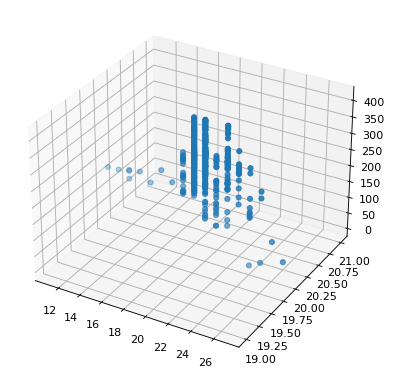

In [86]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

for i in [1, 2, 15, 20]:
    fig = plt.figure(figsize=(10, 6), dpi=80)
    ax = fig.add_subplot(111, projection='3d')

    x2 = df.loc[df['Classement final']==i, 'Classement final']
    x3 = df.loc[df['Classement final']==i, 'Distance 24h'] 
    x1 = df.loc[df['Classement final']==i, 'Classement']
    
    ax.scatter(x1, x2, x3)

In [ ]:
# Génération de données selon une loi normale tridimensionnelle
x3 = df['Distance 24h'] 
x2 = df['Classement final'] 
x1 = df['Classement']

# Affichage du nuage de points
fig = plt.figure(figsize=(20, 20), dpi=80)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, x3)

ax.set_zlabel('Distance 24h')
ax.set_ylabel('Classement final')
ax.set_xlabel('Classement')
plt.title("Données initiales")
plt.show()

In [ ]:
# séries temporelles
# évolution de la position du bateau dans le classement par rapport à l'ordre d'arrivée



In [ ]:
# évolution de la vitesse par tranche de latitude
# distance / vitesse pour vérifier corrélation
# vitesse / présence foil
# classement / présence foil
# cl et vit / foil
# 

In [ ]:

# Fixing random state for reproducibility
np.random.seed(19680801)

# some random data
x = np.random.randn(500)
y = np.random.randn(500)


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')
    
# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(x, y, ax, ax_histx, ax_histy)

plt.show()

* Rapprochement des données des voiliers avec celle des classements.
* Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers.
* Impact de la présence d'un foil sur le classement et la vitesse des voiliers.
* Visualisation de la distance parcourue par voilier.
* Cartes avec les routes d'un ou plusieurs voiliers.
* Analyses de séries temporelles.
* Application d'algorithmes statistiques ou de machine learning.
* etc.